# <center><span style="color: #FFB6C1">**1. Introdução**</span></center>

## <span style="color: #FFB6C1">**1.1 Visão Geral e Objetivos do Projeto:**
Este projeto visa desenvolver um sistema de intervenção académica usando machine learning para prever se um aluno do ensino secundário passará ou chumbará no exame final, tendo como base fatores demográficos, académicos e sociais. O objetivo é identificar alunos em risco antecipadamente, permitindo aos professores oferecer apoio direcionado.

## <span style="color: #FFB6C1">**1.2 Objetivos principais:**
- Análise exploratória (EDA) para compreender padrões nos dados.
- Pré-processamento (dados faltantes, outliers, codificação de variáveis categóricas).
- Treino e avaliação de modelos de classificação (Regressão Logística, Árvores de Decisão, KNN).
- Comparação de métricas de desempenho (precisão, recall, AUC-ROC).
- Interpretação dos resultados para identificar fatores críticos no desempenho dos alunos.

## <span style="color: #FFB6C1">**1.3 Descrição do Dataset:**
**Características principais:**
- **Dados demográficos:** idade (15-22), sexo, localização (urbano/rural)
- **Contexto familiar:** educação dos pais (Medu/Fedu 1-4), status conjugal (Pstatus), tamanho da família
- **Fatores académicos:** reprovações anteriores (failures), tempo de estudo, apoio escolar
- **Comportamentais:** consumo de álcool (Dalc/Walc), vida social (goout), atividades extracurriculares
- **Variável alvo:** `passed` (binária: aprovação no ano letivo)

**Exemplo de variáveis críticas:**
- `absences`: Número total de faltas (0-93)
- `Medu`: Educação materna (0-nenhuma a 4-superior)
- `failures`: Número de reprovações anteriores (0-3+)
- `Dalc`: Consumo de álcool dia de semana (1-baixo a 5-alto)

## <span style="color: #FFB6C1">**1.5 Relevância:**
Permite intervenções personalizadas para melhorar resultados académicos.
Modelos interpretáveis ajudam a identificar factores de risco (ex.: faltas, nível educacional dos pais).

<hr style="height:4px;border-width:0;color:#FFB6C1;background-color:#FFB6C1">


# <center><span style="color: #FFB6C1">**2. Organização**

### <span style="color: #FFB6C1">**Antes de correr o código ! :**

### Requisitos de instalação:
- pandas
- numpy
- scikit-learn
- balanced-learn
- matplotlib
- seaborn
- streamlit
- joblib
- shap
- pyyaml

### Estrutura de pastas
mkdir -p data/raw data/processed datascapp.py

### Coloque seu arquivo student-data.csv em data/raw/!

## <span style="color: #FFB6C1">**2.1 Imports necessários:**

Para correr os códigos presentes neste projeto, é necessário importar as seguintes bibliotecas:

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split, KFold, cross_validate, learning_curve, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer, roc_curve
from imblearn.over_sampling import RandomOverSampler
import shap
from sklearn.impute import KNNImputer
import yaml
from pathlib import Path
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import ttest_rel
from category_encoders import TargetEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.preprocessing import FunctionTransformer

## <span style="color: #FFB6C1">**2.2 Paths:**

In [47]:
# por o seu próprio path (fulll) para o student data (deveria acabar por /data/raw/student-data.csv)!!
config_yml = """
paths:
  raw_data: "/Users/mathilde/Documents/FINALNOTEBOOK/data/raw/student-data.csv" 
  processed: 
    train: "data/processed/train_cleaned.csv"
    test: "data/processed/test_cleaned.csv"

preprocessing:
  clip:
    absences_clip: 10
  encoding:
    rare_category_threshold: 0.05
    rare_category_name: "other"
  sampling:
    test_size: 0.2
    random_state: 42
  feature_selection:
    k: 15
  imputation:
    num_strategy: "knn"
    cat_strategy: "most_frequent"

eda:
  style: "seaborn-v0_8"            
  dpi: 300                            
  figure_size:
    small: [6, 4]                     
    medium: [8, 6]                 
    large: [10, 8]                   
  numeric_cols:                      
    - "age"
    - "Medu"
    - "Fedu"
    - "traveltime"
    - "studytime"
    - "failures"
    - "famrel"
    - "freetime"
    - "goout"
    - "Dalc"
    - "Walc"
    - "health"
    - "absences"
"""

config = yaml.safe_load(config_yml)

<p style="margin-bottom: 50px;"></p>  <!-- Espaço de 50px -->

<hr style="height:4px;border-width:0;color:#FFB6C1;background-color:#FFB6C1">



# <center><span style="color: #FFB6C1">**3. Análise Exploratória de Dados (EDA)**</span></center>

A Análise Exploratória de Dados (EDA) é uma etapa fundamental no processo de análise, onde procuramos compreender a estrutura, as características e os padrões presentes no conjunto de dados. Por meio de técnicas estatísticas e visualizações gráficas, a EDA permite identificar tendências, detetar possíveis inconsistências e guiar decisões para o pré-processamento e modelagem, garantindo que os dados estejam adequados para análises mais aprofundadas.

## <span style="color: #FFB6C1">**3.1 Carregamento de dados:**

In [48]:
# Configurações de visualização
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.dpi'] = 100
sns.set_palette("husl")

## 3.1 Carregamento dos Dados
print("=== 📂 CARREGAMENTO DOS DADOS ===")

try:
    df = pd.read_csv("data/raw/student-data.csv")
    print("✅ Dados carregados com sucesso!")

    # Verificar coluna target
    if 'passed' not in df.columns:
        raise ValueError("Coluna 'passed' não encontrada no dataset")

    print(f"\n📊 Dimensões do dataset: {df.shape[0]} alunos x {df.shape[1]} características")
    print(f"\n🔍 Primeiras linhas:")
    display(df.head(3))

except Exception as e:
    print(f"❌ Erro ao carregar dados: {e}")
    raise

expected_columns = 31  # From your sample data
if df.shape[1] != expected_columns:
    missing_cols = set(expected_columns) - set(df.columns)
    raise ValueError(f"Data loading error! Missing columns: {missing_cols}")

# Verificar dados ausentes
missing_data = df.isnull().sum()
print("Valores ausentes por coluna:")
print(missing_data[missing_data > 0])

# Imputação com KNNImputer
# Separate numerical and categorical data
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Apply KNNImputer only to numerical data
imputer = KNNImputer(n_neighbors=5)
df_imputed_numeric = pd.DataFrame(imputer.fit_transform(df[numeric_cols]), columns=numeric_cols)

# Combine the imputed numerical data with the categorical data
df_imputed = pd.concat([df_imputed_numeric, df[categorical_cols]], axis=1)





=== 📂 CARREGAMENTO DOS DADOS ===
✅ Dados carregados com sucesso!

📊 Dimensões do dataset: 395 alunos x 31 características

🔍 Primeiras linhas:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes


Valores ausentes por coluna:
Series([], dtype: int64)


## <span style="color: #FFB6C1">**3.2 Análise da variável target:**

O seguinte código analisa a variável alvo (passed), que indica se um aluno passou ou não.

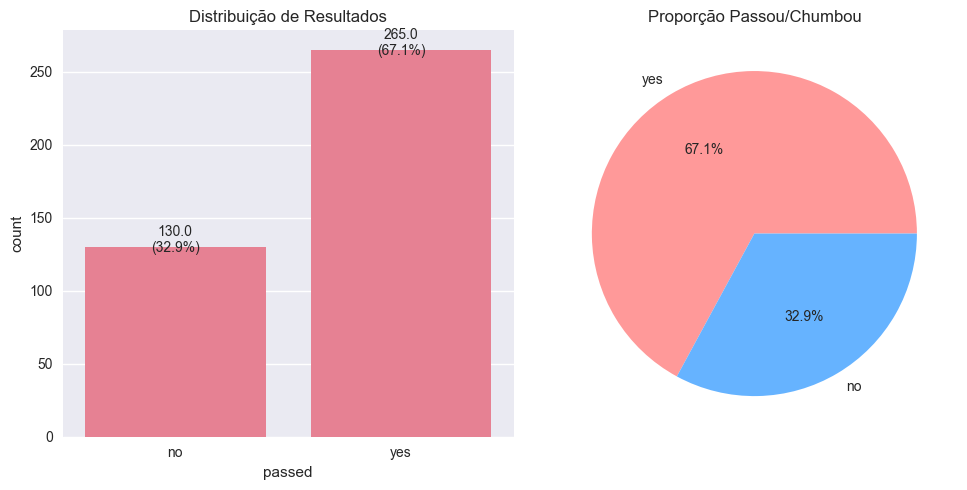

In [49]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
ax = sns.countplot(x='passed', data=df_imputed, order=['no', 'yes'])
plt.title('Distribuição de Resultados')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}\n({p.get_height()/len(df_imputed)*100:.1f}%)',
               (p.get_x()+p.get_width()/2., p.get_height()),
               ha='center', va='center', xytext=(0,5), textcoords='offset points')

plt.subplot(1,2,2)
df_imputed['passed'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title('Proporção Passou/Chumbou')
plt.ylabel('')

plt.tight_layout()
plt.show()

passed_distribution = df_imputed['passed'].value_counts(normalize=True)
if (passed_distribution['yes'] < 0.3) or (passed_distribution['yes'] > 0.7):
    raise ValueError("Unexpected class distribution in target variable")

Os gráficos mostram que:
* 265 alunos (67,1%) foram aprovados.
* 130 alunos (32,9%) foram reprovados. 

## <span style="color: #FFB6C1">**3.3 Análise de características numéricas:**

Esta tabela realiza uma análise descritiva das variáveis numéricas relacionadas ao desempenho acadºemico dos alunos. O objetivo é entender a distribuição e o comportamento dessas características, que podem influenciar diretamente na aprovação ou reprovação dos estudantes.

In [50]:
# Selecionar colunas numéricas relevantes
numeric_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


print("\n📈 Estatísticas Descritivas:")
display(df_imputed[numeric_cols].describe().T.style.background_gradient(cmap='Blues'))


📈 Estatísticas Descritivas:


,count,mean,std,min,25%,50%,75%,max
age,395.000000,16.696203,1.276043,15.000000,16.000000,17.000000,18.000000,22.000000
Medu,395.000000,2.749367,1.094735,0.000000,2.000000,3.000000,4.000000,4.000000
Fedu,395.000000,2.521519,1.088201,0.000000,2.000000,2.000000,3.000000,4.000000
traveltime,395.000000,1.448101,0.697505,1.000000,1.000000,1.000000,2.000000,4.000000
studytime,395.000000,2.035443,0.839240,1.000000,1.000000,2.000000,2.000000,4.000000
failures,395.000000,0.334177,0.743651,0.000000,0.000000,0.000000,0.000000,3.000000
famrel,395.000000,3.944304,0.896659,1.000000,4.000000,4.000000,5.000000,5.000000
freetime,395.000000,3.235443,0.998862,1.000000,3.000000,3.000000,4.000000,5.000000
goout,395.000000,3.108861,1.113278,1.000000,2.000000,3.000000,4.000000,5.000000
Dalc,395.000000,1.481013,0.890741,1.000000,1.000000,1.000000,2.000000,5.000000


### Explicação da Tabela
A tabela mostra para cada variável:
* count: número total de observações (395 para todas, sem dados faltantes)
* mean: média dos valores
* std: desvio padrão (medida de dispersão)
* min/max: valores mínimo e máximo
* 25%/50%/75%: quartis (distribuição dos dados)
### Conclusões:
1. **Perfil Demográfico dos Alunos**
* A maioria tem entre 16 e 18 anos (média = 16,7), com alguns casos de alunos mais velhos (até 22 anos).
2. **Fatores Familiares**
* Mães têm escolaridade ligeiramente maior que pais (média 2,75 vs. 2,52).
* Relações familiares são boas (média 3,94/5).
3. **Hábitos de Estudo e Desempenho**
* Tempo de estudo é baixo (75% estudam ≤ 2h numa escala de 1-4).
4. **Comportamentos de Risco**
* Consumo de álcool é maior nos fins de semana (Walc = 2,29 vs. Dalc = 1,48).
5. **Faltas (absences)**
* Média de 5,7 faltas, sendo 75 o máximo de faltas

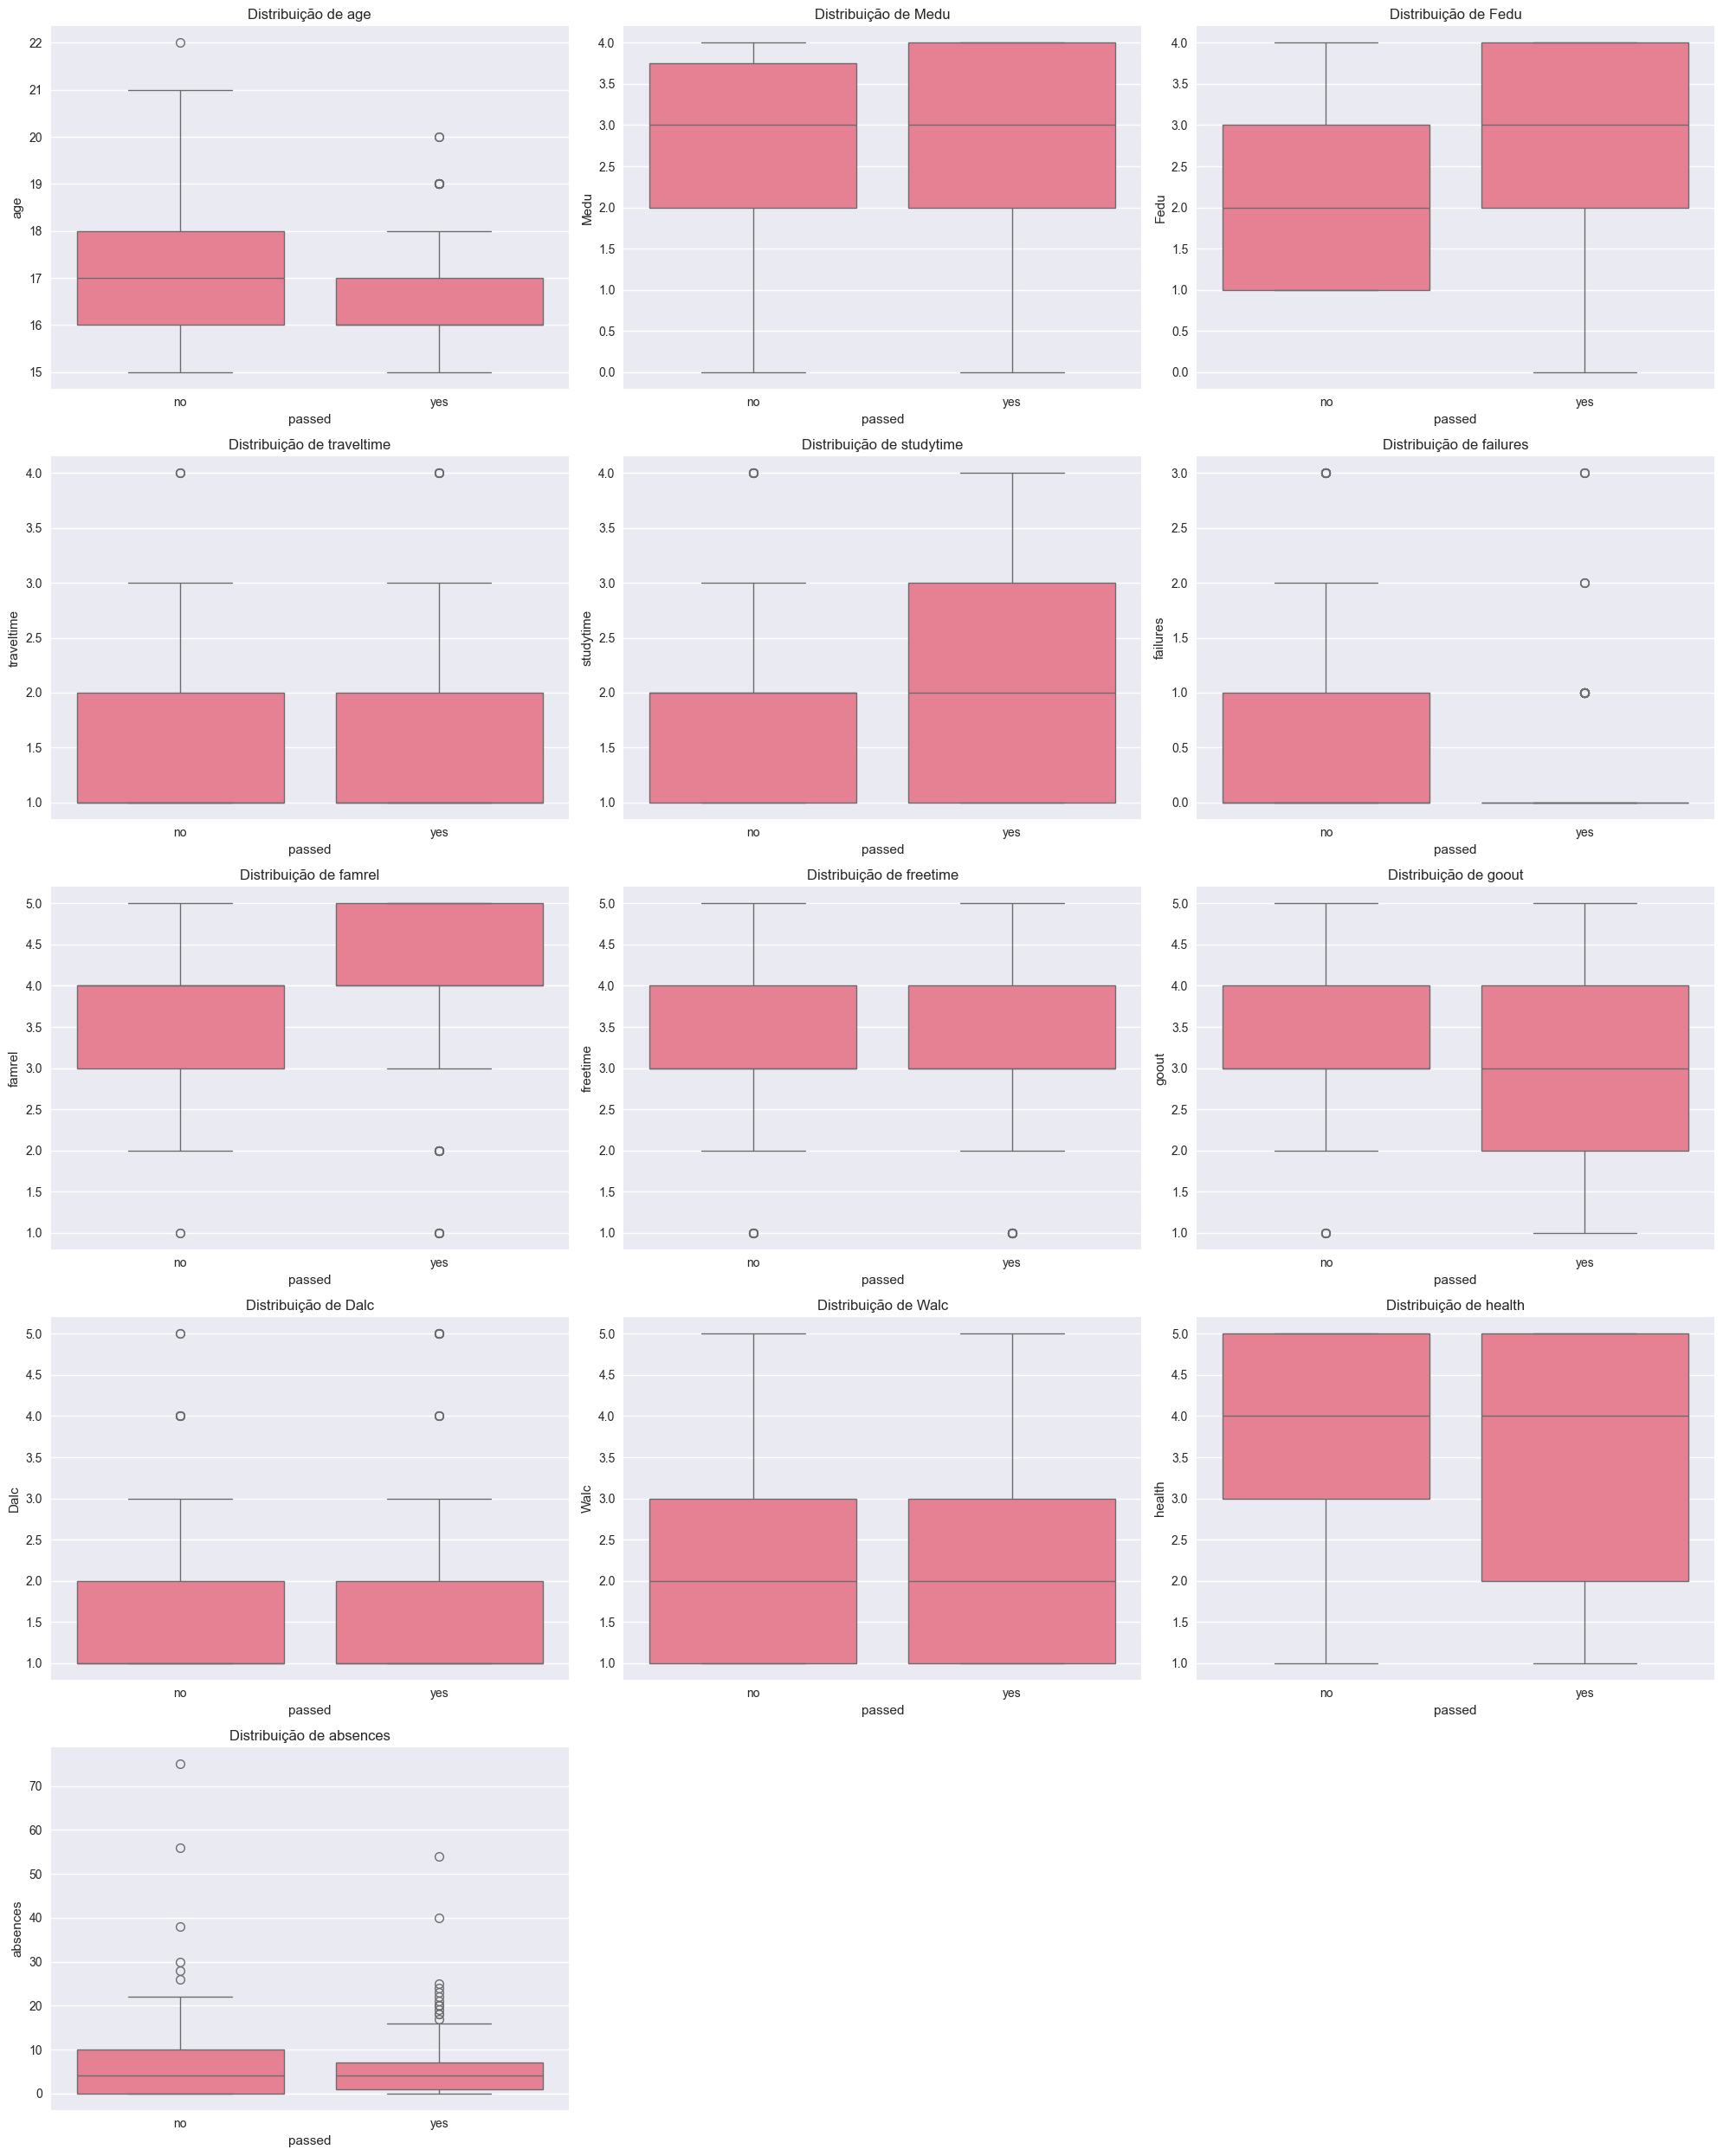

In [51]:
# Visualização das distribuições
plt.figure(figsize=(20,25))
rows = (len(numeric_cols) + 2) // 3
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 3, i) 
    sns.boxplot(x='passed', y=col, data=df_imputed, order=['no', 'yes'])
    plt.title(f'Distribuição de {col}')
plt.tight_layout()
plt.show()

Os gráficos acima mostram a distribuição de variáveis numéricas em relação à aprovação/reprovação dos alunos ("passed"), utilizando diagramas de caixa (boxplots). Cada gráfico compara como cada variável se distribui entre alunos que passaram ("yes") e não passaram ("no"). Exemplo :

1. **Distribuição de Age (Idade):**
* Alunos reprovados ("no") tendem a ser ligeiramente mais velhos (mediana mais alta)
* Maior dispersão nas idades dos reprovados
* Sugere que alunos mais velhos (possivelmente repetentes) têm maior chance de reprovação
2. **Distribuição de Medu (Educação da Mãe):**
* Alunos aprovados têm mães com nível de escolaridade mais alto (mediana maior)
3. **Distribuição de Fedu (Educação do Pai):**
* Padrão similar ao da educação materna, confirmando que educação parental influencia no desempenho
4. **Distribuição de Traveltime (Tempo de Deslocamento):**
* Não possui impacto aparente.
5. **Distribuição de Studytime (Tempo de Estudo):**
* Diferença clara: aprovados estudam mais (mediana maior)
* Tempo de estudo é fator crucial para aprovação
6. **Distribuição de Failures (Reprovações Anteriores):**
* Reprovados têm mais failures
* Distribuição muito assimétrica para os reprovados
* Histórico escolar é forte preditor de desempenho futuro

Nomeadamente, com estes gráficos, podemos observar diversos outliers de teremos que remover no pré-processamento de dados

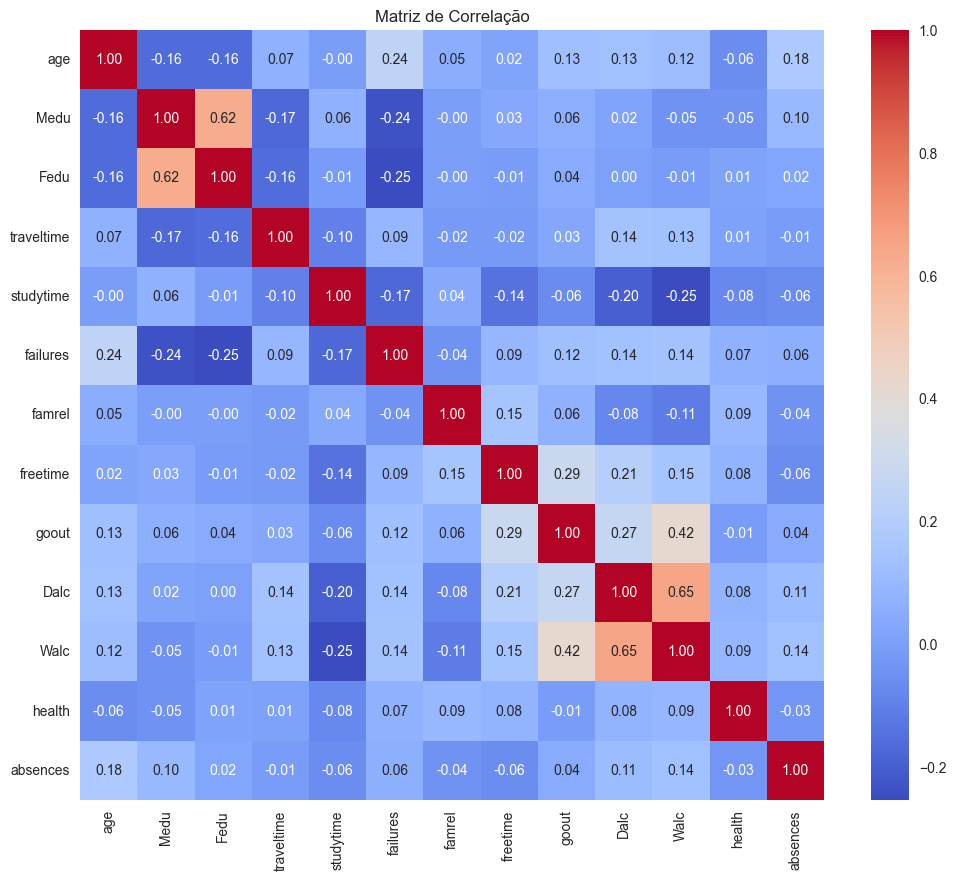

In [52]:
# Verificar correlação entre variáveis numéricas
plt.figure(figsize=(12,10))
corr_matrix = df_imputed.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

A matriz de correlação mostra como as variáveis numéricas do conjunto de dados se relacionam entre si, medindo a intensidade e a direção (positiva ou negativa) dessas relações. Cada célula da matriz indica o coeficiente de correlação (de -1 a 1), onde:

* Valores próximos de 1: Correlação positiva forte (quanto maior X, maior Y).
* Valores próximos de -1: Correlação negativa forte (quanto maior X, menor Y).
* Valores próximos de 0: Pouca ou nenhuma relação linear.

Dada a matriz, tiramos as seguintes conclusões:

* Fatores que mais influenciam a aprovação: Educação dos pais, maior tempo de estudo.
* Fatores de risco: Rreprovações anteriores e faltas.
* Variáveis com pouca influência: Saúde (health) e tempo de deslocamento (traveltime).

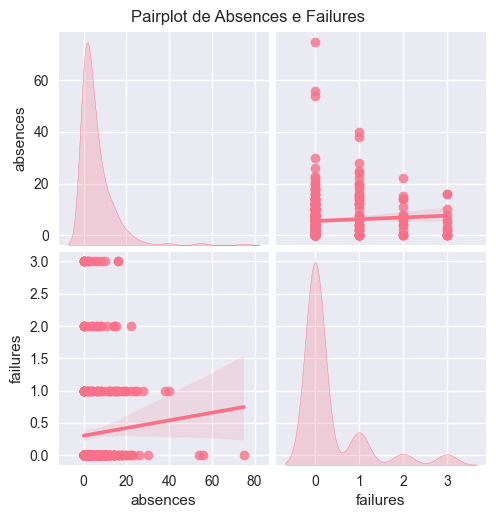

In [53]:
# Pairplot para notas
sns.pairplot(df_imputed[['absences', 'failures']], kind='reg', diag_kind='kde')
plt.suptitle("Pairplot de Absences e Failures", y=1.02)
plt.show()

Estes gráficos mostram a relação entre o número de faltas (absences) e o número de reprovações (failures). Há uma tendência de que mais faltas estejam associadas a um maior número de reprovações, sugerindo que a assiduidade pode influenciar o sucesso acadêmico.

## <span style="color: #FFB6C1">**3.4 Análise de características categóricas:**

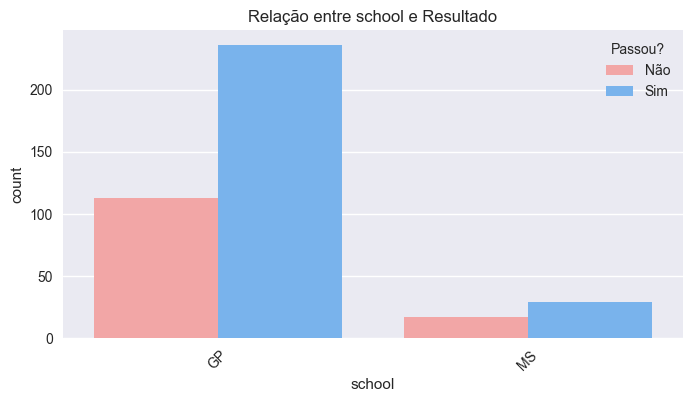

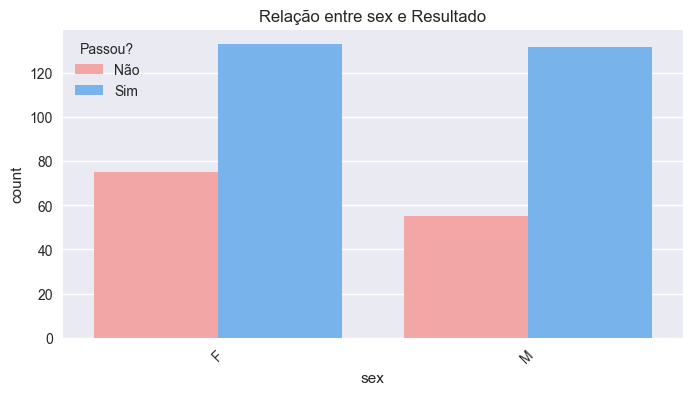

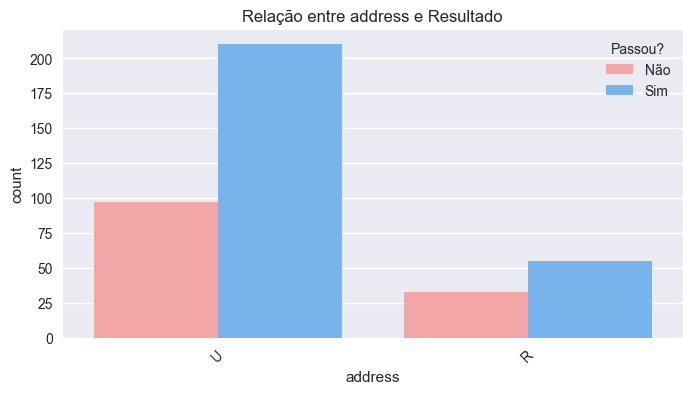

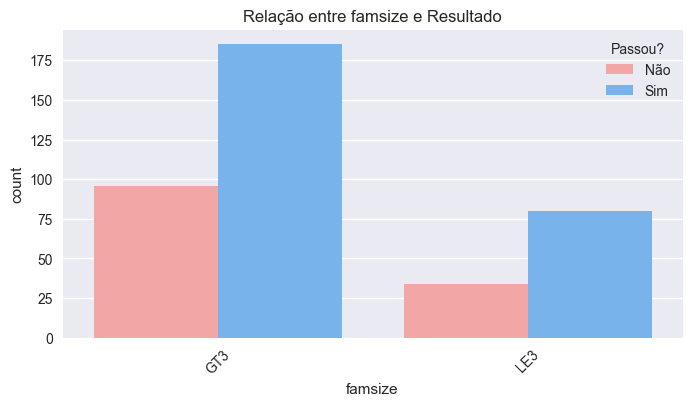

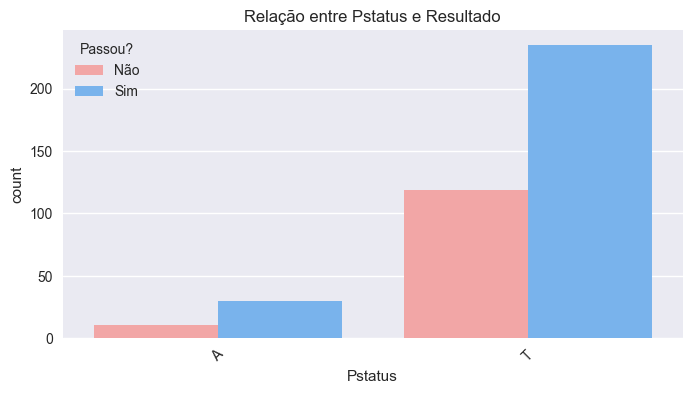

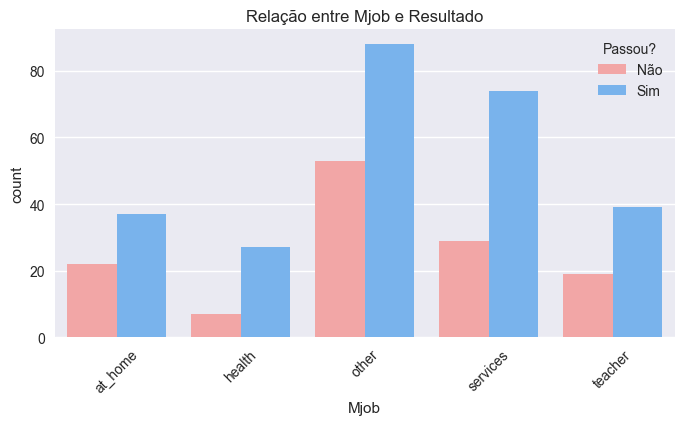

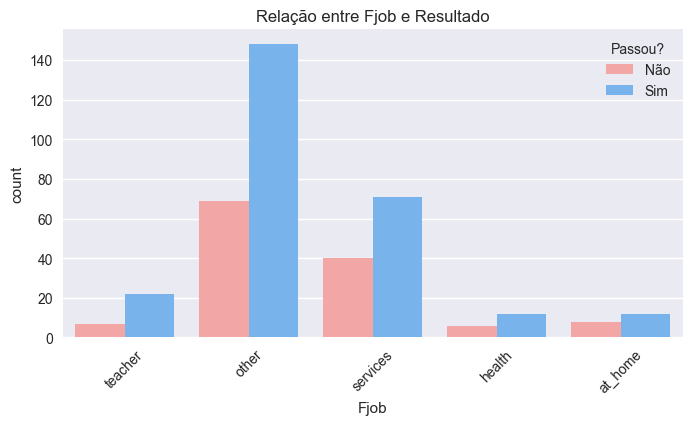

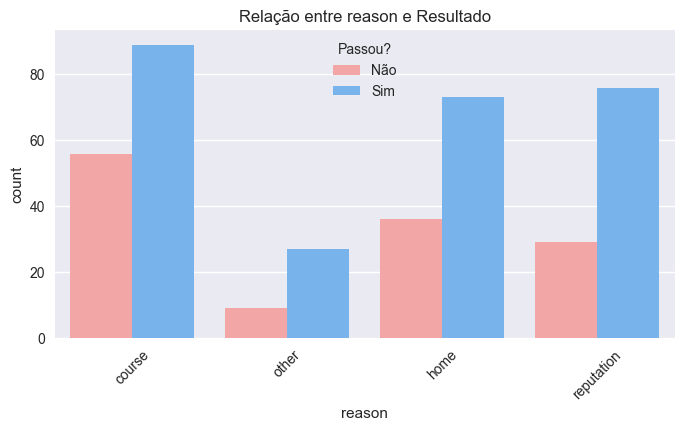

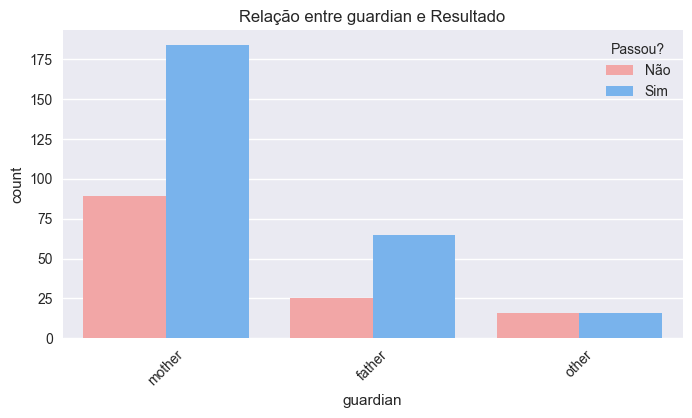

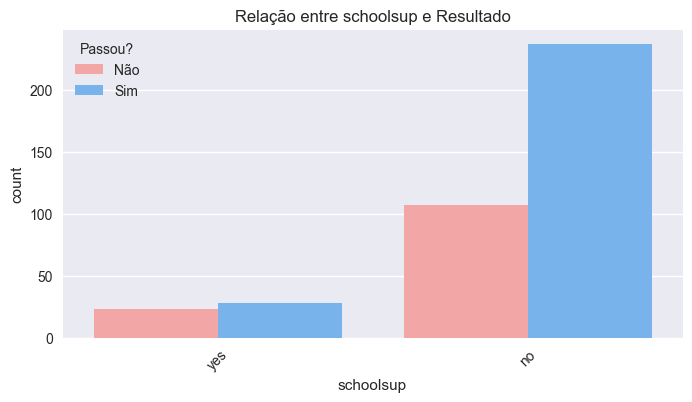

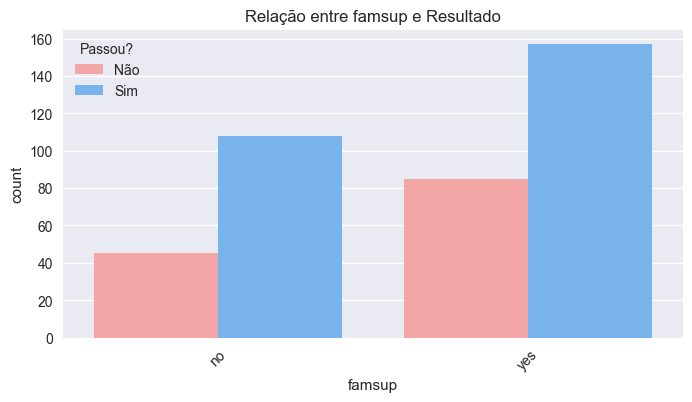

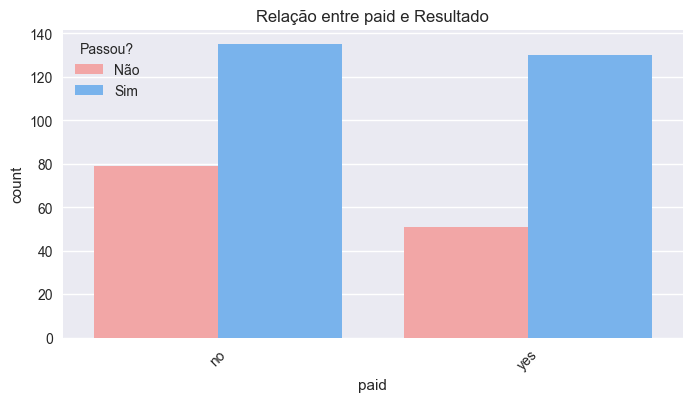

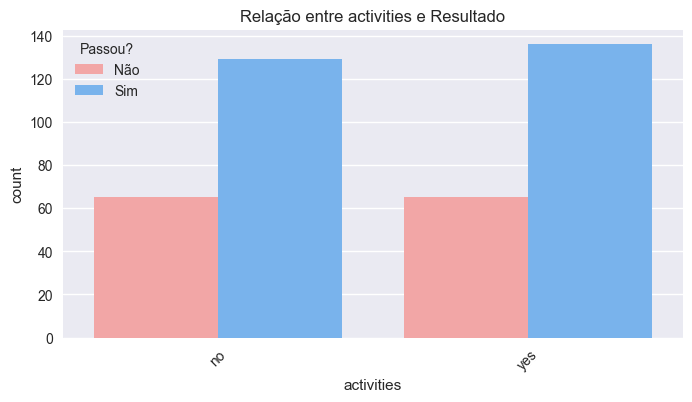

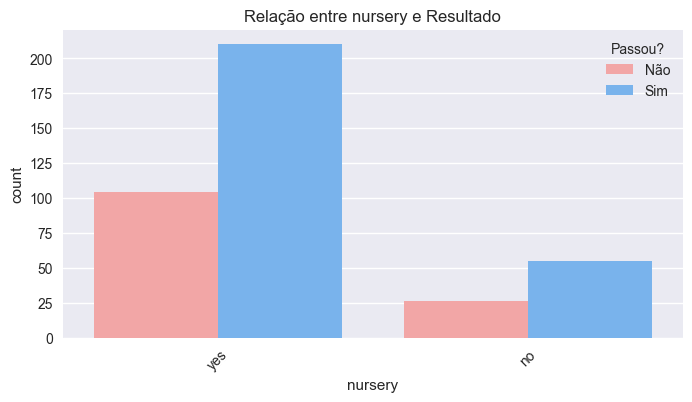

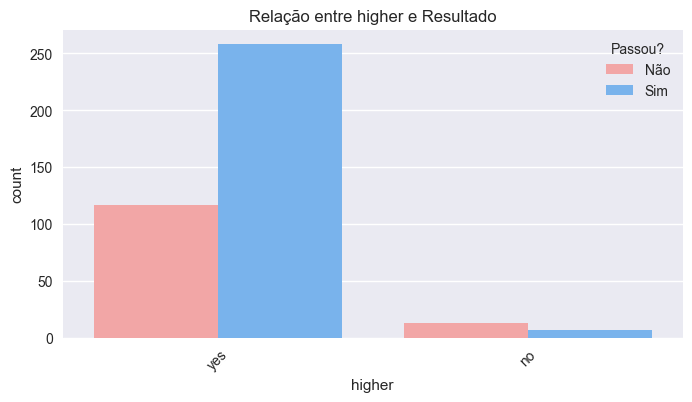

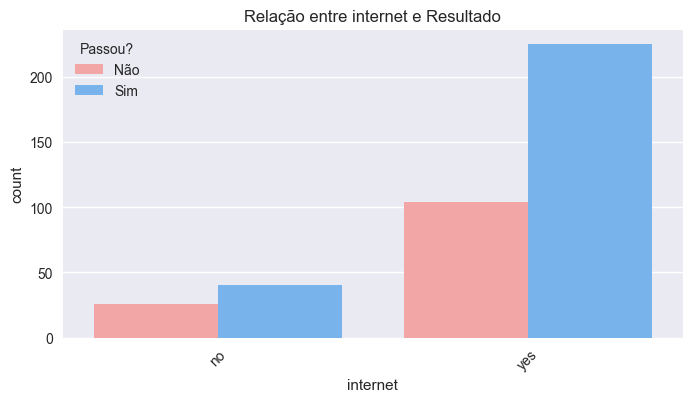

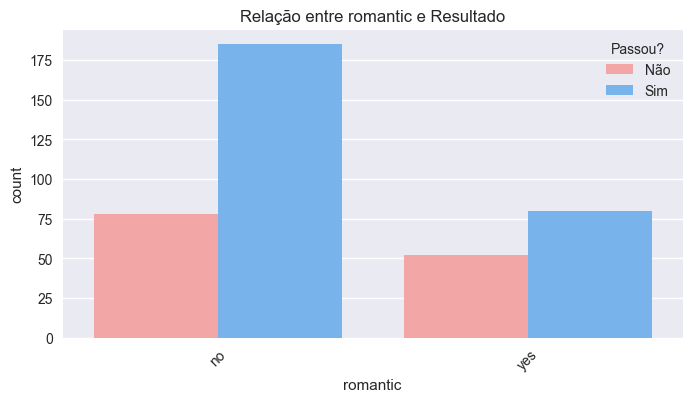

In [54]:
categorical_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
                    'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
                    'nursery', 'higher', 'internet', 'romantic']

# Análise das principais categóricas
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='passed', data=df_imputed, hue_order=['no', 'yes'], palette=['#ff9999','#66b3ff'])
    plt.title(f'Relação entre {col} e Resultado')
    plt.xticks(rotation=45)
    plt.legend(title='Passou?', labels=['Não', 'Sim'])
    plt.show()

### Conclusões
Os gráficos mostram a relação entre diferentes características categóricas dos alunos e seus resultados (aprovação/reprovação). Vamos analisar alguns :

1. **Relação entre escola (GP/MS) e resultado**
* Observa-se uma diferença significativa na proporção de aprovações entre as escolas.
* A escola GP apresenta um volume maior de dados (mais alunos) que a MS.

2. **Relação entre sexo (F/M) e resultado**
* F (Female) vs M (male)
* Compara o desempenho entre alunos femininos e masculinos
* Alunas F apresentam maior taxa de reprovação.

3. **Relação entre endereço (U/R) e resultado**
* U (Urbano) vs (Rural)
* A quantidade de alunos que moram em zonas urbanas é maior do que os de zonas rurais.
* A análise revela que moradores de zonas urbanas tem maior índice de aprovação em comparação com os da zona rural.

4. **Relação entre tamanho da família (GT3/LE3) e resultado**
* GT3 (família grande: >3 membros) vs LE3 (família pequena: ≤3 membros)
* Famílias menores (LE3) tendem a ter maior proporção de aprovações.
* Famílias maiores (GT3) mostram maior taxa de reprovação.

5. **Relação entre status parental (A/T) e resultado**
* A (apart/separados) vs T (together/juntos)
* indica que a estabilidade familiar (ter pais juntos) favorece o desempenho.

## <span style="color: #FFB6C1">**3.5 Análise de relações chave:**

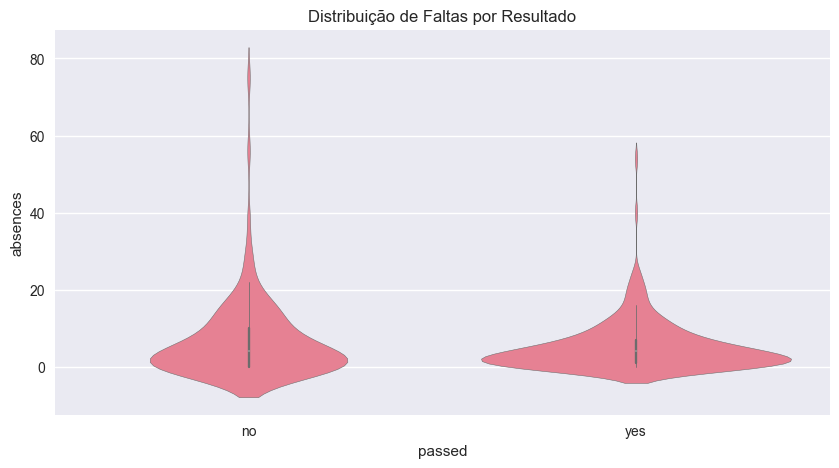

In [55]:
# Relação entre faltas e resultado
plt.figure(figsize=(10,5))
sns.violinplot(x='passed', y='absences', data=df_imputed, order=['no', 'yes'])
plt.title('Distribuição de Faltas por Resultado')
plt.show()

O gráfico mostra que alunos com poucas faltas tendem a passar e que aqueles com um número de faltas elevado são mais propensos a serem reprovados.

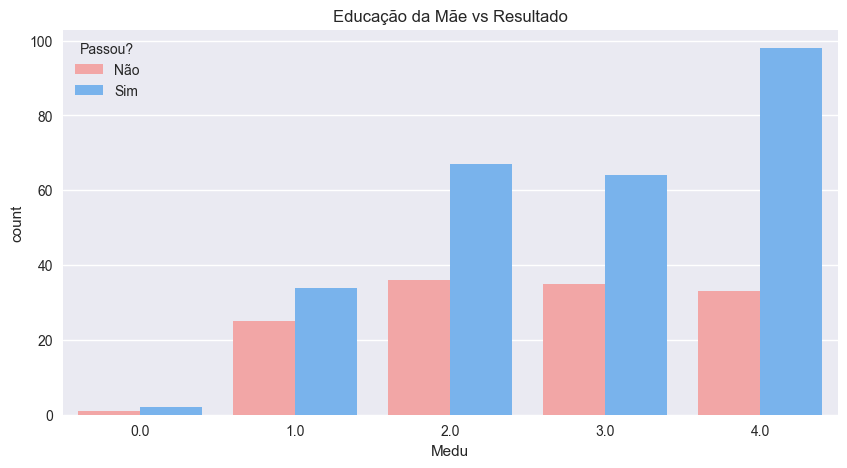

In [56]:
# Relação entre educação dos pais e resultado
plt.figure(figsize=(10,5))
sns.countplot(x='Medu', hue='passed', data=df_imputed, hue_order=['no', 'yes'], palette=['#ff9999','#66b3ff'])
plt.title('Educação da Mãe vs Resultado')
plt.legend(title='Passou?', labels=['Não', 'Sim'])
plt.show()

A análise do gráfico confirma que o nível de educação formal da mãe impacta diretamente o sucesso escolar do(a) filho(a), com uma clara predominância de aprovações entre os filhos de mães com maior formação académica.

## <span style="color: #FFB6C1">**3.6 Testes estatísticos:**

In [57]:
results = []
for col in numeric_cols:
    passou = df_imputed[df_imputed['passed'] == 'yes'][col]
    chumbou = df_imputed[df_imputed['passed'] == 'no'][col]

    t_stat, p_val = ttest_ind(passou, chumbou)
    effect_size = (passou.mean() - chumbou.mean()) / np.sqrt((passou.std()**2 + chumbou.std()**2)/2)

    results.append({
        'Variável': col,
        'Média (Passou)': f"{passou.mean():.2f}",
        'Média (Chumbou)': f"{chumbou.mean():.2f}",
        'Diferença': f"{passou.mean()-chumbou.mean():.2f}",
        'p-valor': f"{p_val:.4f}",
        'Effect Size': f"{effect_size:.2f}",
        'Significativo?': 'Sim' if p_val < 0.05 else 'Não'
    })

display(pd.DataFrame(results).sort_values('p-valor').style.background_gradient(
    subset=['p-valor', 'Effect Size'], cmap='YlOrRd'))

,Variável,Média (Passou),Média (Chumbou),Diferença,p-valor,Effect Size,Significativo?
5,failures,0.16,0.69,-0.53,0.0000,-0.68,Sim
8,goout,2.97,3.40,-0.43,0.0002,-0.39,Sim
0,age,16.54,17.02,-0.49,0.0003,-0.38,Sim
1,Medu,2.84,2.57,0.27,0.0218,0.25,Sim
2,Fedu,2.60,2.35,0.25,0.0318,0.23,Sim
12,absences,5.19,6.76,-1.57,0.0670,-0.18,Não
4,studytime,2.08,1.95,0.13,0.1388,0.16,Não
11,health,3.49,3.68,-0.19,0.1928,-0.14,Não
9,Dalc,1.45,1.55,-0.11,0.2555,-0.12,Não
6,famrel,3.97,3.88,0.09,0.3548,0.10,Não


Esta tabela compara a média de diversas variáveis para dois grupos: alunos que passaram ("Média (Passou)") e alunos que reprovaram ("Média (Chumbou)"). As colunas "Diferença", "p-valor", "Effect Size" e "Significativo?" indicam a relevância estatística e a magnitude da diferença entre esses grupos.

Os fatores mais fortemente associados à **reprovação** são um maior número de **reprovações anteriores (failures), faltas (absences) e uma idade ligeiramente mais avançada.** Por outro lado, um **nível educacional mais alto dos pais (Medu e Fedu)** parece estar associado a um **maior sucesso acadêmico.** 

## <span style="color: #FFB6C1">**3.7 Principais Conclusões da EDA:**

### <span style="color: #FFB6C1">1. Distribuição do Desfecho (Target):**
- A análise da variável *target* revelou que a maioria dos alunos foi aprovada (aproximadamente **67.1%**), enquanto uma parcela menor reprovou (**32.9%**).
- **Recomendação:** sugere-se a utilização de métricas de avaliação de modelo como *Recall* e *F1-Score* para garantir a minimização de falsos positivos e uma avaliação robusta do desempenho.

### <span style="color: #FFB6C1">**Fatores de Maior Relevância para o Desempenho Acadêmico:**
- **Assiduidade (Absences):** Houve uma diferença estatisticamente significativa no número de faltas entre os grupos de alunos aprovados e reprovados.
- **Nível Educacional dos Pais (Medu/Fedu):** Observou-se uma correlação positiva, indicando que um maior nível de escolaridade da mãe e do pai está associado a uma maior probabilidade de aprovação do aluno.
- **Histórico de Reprovações (Failures):** Um número elevado de reprovações anteriores demonstrou ser o fator mais fortemente associado à reprovação atual, com uma diferença altamente significativa entre os grupos.

<p style="margin-bottom: 50px;"></p>  <!-- Espaço de 50px -->

<hr style="height:4px;border-width:0;color:#FFB6C1;background-color:#FFB6C1">


# <center><span style="color: #FFB6C1">**4. Pré-processamento dos Dados**

Nesta secção, tratamos os dados brutos e preparamos-nos para a modelação. Isso inclui:
- Limpeza dos dados (clipping e categorias raras)
- Codificação de variáveis categóricas (Label Enconding)
- Normalização e Padronização
- Separação treino/teste
- Reamostragem para classes desbalanceadas (oversampling)

In [58]:
def load_data(filepath):
    #Load dataset with error handling.
    try:
        # Tenta ler o arquivo CSV usando pandas
        return pd.read_csv(filepath)
    except FileNotFoundError:
        # Se o arquivo não for encontrado, levanta uma exceção com mensagem informativa
        raise FileNotFoundError(f"Data file not found at {filepath}")

In [59]:
def clean_raw_data(df):
    """Apply basic cleaning: clipping and rare category replacement.
    
    Args:
        df (DataFrame): DataFrame contendo os dados brutos
        
    Returns:
        DataFrame: DataFrame após limpeza básica
    """
    # Clipa valores máximos de faltas (absences) conforme configurado
    df['absences'] = df['absences'].clip(upper=config['preprocessing']['clip']['absences_clip'])

    # Substitui categorias raras nas colunas de trabalho dos pais
    for col in ['Mjob', 'Fjob']:
        # Calcula frequência relativa de cada categoria
        counts = df[col].value_counts(normalize=True)
        # Identifica categorias abaixo do threshold configurado
        rare = counts[counts < config['preprocessing']['encoding']['rare_category_threshold']].index
        # Substitui categorias raras pelo nome configurado
        df[col] = df[col].replace(rare, config['preprocessing']['encoding']['rare_category_name'])

    return df

def validate_preprocessing(df):
    """Validate that preprocessing addressed EDA findings.
    
    Args:
        df (DataFrame): DataFrame após pré-processamento
        
    Raises:
        AssertionError: Se alguma validação falhar
    """
    # Verifica se o clipping de faltas foi aplicado corretamente
    absences_clip = config['preprocessing']['clip']['absences_clip']
    assert df['absences'].max() <= absences_clip, "Absences not clipped properly"

    # Valida tratamento de categorias raras em cada coluna especificada
    for col in ['Mjob', 'Fjob']:
        counts = df[col].value_counts(normalize=True)
        assert all(counts >= config['preprocessing']['encoding']['rare_category_threshold']), f"Rare categories not handled in {col}"

    # Garante que a variável target tenha ambas classes representadas
    assert df['passed'].nunique() == 2, "Target variable does not have both classes represented"

def preprocess_data(df):
    """Main preprocessing pipeline.
    
    Args:
        df (DataFrame): DataFrame contendo os dados brutos
        
    Returns:
        tuple: Contém:
            - X_train: Features de treino
            - X_test: Features de teste
            - y_train: Target de treino
            - y_test: Target de teste
            - scaler: Objeto scaler usado
            - numeric_cols: Lista de colunas numéricas
            - le: LabelEncoder usado
    """
    # Separa features (X) e target (y)
    X = df.drop('passed', axis=1)
    y = df['passed']

    # Codifica target (transforma classes em 0/1) 
    #(NOTA: 0 = reprovados (no) e 1 = aprovados (tendo em conta que o label encoder, por definição, atribui os valores por ordem alfabética -> no < yes)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    

    # Divide dados em treino e teste com estratificação
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=config['preprocessing']['sampling']['test_size'],
        random_state=config['preprocessing']['sampling']['random_state'],
        stratify=y_encoded
    )

    # Aplica one-hot encoding para colunas categóricas
    categorical_cols = X.select_dtypes(include=['object']).columns
    X_train = pd.get_dummies(X_train, columns=categorical_cols)
    X_test = pd.get_dummies(X_test, columns=categorical_cols)

    # Garante que treino e teste tenham as mesmas colunas (pós one-hot)
    missing_cols = set(X_train.columns) - set(X_test.columns)
    for col in missing_cols:
        X_test[col] = 0
    X_test = X_test[X_train.columns]

    columns_order = list(X_train.columns)
    joblib.dump(columns_order, "columns_order.pkl")

    # Balanceia classes usando oversampling
    ros = RandomOverSampler(random_state=config['preprocessing']['sampling']['random_state'])
    X_train, y_train = ros.fit_resample(X_train, y_train)

    # Normaliza features numéricas usando MinMaxScaler
    numeric_cols = config['eda']['numeric_cols']
    scaler = MinMaxScaler()
    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

    return X_train, X_test, y_train, y_test, scaler, numeric_cols, le

def main():
    """Pipeline principal de pré-processamento."""
    # Carrega e limpa dados brutos
    df = load_data(config['paths']['raw_data'])
    df = clean_raw_data(df)
    validate_preprocessing(df)

    # Aplica pré-processamento completo
    X_train, X_test, y_train, y_test, scaler, numeric_cols, label_encoder = preprocess_data(df)

    # Guarda dados processados
    # Concatena features e target para formar datasets completos
    train_processed = pd.concat([X_train, pd.Series(y_train, name='passed')], axis=1)
    test_processed = pd.concat([X_test, pd.Series(y_test, name='passed')], axis=1)
    
    # Garante que diretório de destino existe e guarda os dados
    Path(config['paths']['processed']['train']).parent.mkdir(parents=True, exist_ok=True)
    train_processed.to_csv(config['paths']['processed']['train'], index=False)
    test_processed.to_csv(config['paths']['processed']['test'], index=False)


if __name__ == "__main__":
    # Ponto de entrada do script - executa o pipeline principal
    main()

<p style="margin-bottom: 50px;"></p>  <!-- Espaço de 50px -->

<hr style="height:4px;border-width:0;color:#FFB6C1;background-color:#FFB6C1">


# <center><span style="color: #FFB6C1">**5. Modelagem**

Nesta secção decidimos testar diversos algoritmos de machine learning, podendo assim estabelecer uma comparação entre os diversos e identificar os mais ajustados ao problema (prever se um aluno vai ou não passar):
- Modelos utilizados: Random Forest, Regressão Logística, KNN, Árvore de Decisão
- Avaliação dos modelos: com validação cruzada (k-fold)
- Métricas: Acurácia, Precisão, Recall, F1, ROC-AUC
- Visualização: curva de aprendizagem e matriz de confusão
- Identificação das características mais importantes


## <span style="color: #FFB6C1">**5.1 Modelos utilizados:**

- Random Forest: Conjunto de árvores de decisão que votam para prever resultados. Combina múltiplas decisões para maior precisão, reduzindo overfitting. Ideal para dados complexos e não lineares.

- Regressão Logística: Modelo linear que faz a estimativa probabilística entre 0 e 1 usando uma curva sigmoide. Focado em classificação binária, rápido e interpretável, mas limitado a relações lineares.

- KNN: Classifica com base nos vizinhos mais similares no espaço de features. Não faz suposições sobre os dados, mas exige armazenamento completo do dataset e é sensível a escalas.

- Árvore de Decisão: Estrutura hierárquica de regras "se-então" que divide os dados em segmentos puros. Altamente interpretável, mas propensa a overfitting sem controle de profundidade.

## <span style="color: #FFB6C1">**5.2 Métricas utilizadas para avaliar os modelos:**

- Acurácia (accuracy): Proporção de previsões corretas (positivas e negativas).

- Precisão (precision): Proporção de verdadeiros positivos entre todos os positivos previstos.

- Recall: Proporção de verdadeiros positivos entre todos os positivos reais.

- F1-Score (f1): Média harmónica entre precisão e recall.

- Área sob a curva ROC (roc_auc): Mede a capacidade do modelo em distinguir entre classes.

In [60]:

# Carregamento e preparação dos dados
try:
    # Tenta carregar o dataset de treino processado
    students = pd.read_csv("data/processed/train_cleaned.csv")
    # Separa features (todas colunas exceto última) e target (última coluna)
    X = students.iloc[:, :-1]
    y = students.iloc[:, -1]
except FileNotFoundError:
    print("Error: The file was not found.")
    exit()
except Exception as e:
    print(f"An error occurred: {e}")
    exit()

# Pré-processamento dos dados
# Normalização das features usando StandardScaler (média=0, desvio=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Codificação do target (transforma classes em 0 e 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Configuração da Validação Cruzada K-Fold
k = 5  # Número de folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)  # Configura com embaralhamento

# Definição dos modelos a serem avaliados
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}


# Definição das métricas de avaliação
scoring = {
    'accuracy': make_scorer(accuracy_score),  # Acurácia geral
    'precision': make_scorer(precision_score, zero_division=0, pos_label=0),  # Precisão para classe 1
    'recall': make_scorer(recall_score, pos_label=0),  # Recall para classe 1
    'f1': make_scorer(f1_score, zero_division=0, pos_label=0),  # F1-score para classe 1
    'roc_auc': 'roc_auc'  # Área sob a curva ROC
}

# Treino e avaliação dos modelos usando validação cruzada
results = {}  # Dicionário para armazenar resultados
for name, model in models.items():
    # Executa validação cruzada para cada modelo
    cv_results = cross_validate(
        estimator=model,
        X=X_scaled,  # Features normalizadas
        y=y_encoded,  # Target codificado
        cv=kf,  # Estratégia de validação
        scoring=scoring,  # Métricas definidas
        return_train_score=True,  # Retorna métricas no treino também
        return_estimator=True  # Retorna os modelos treinados em cada fold
    )
    results[name] = cv_results  # Armazena resultados

## Análise dos resultados
print("\nResultados da Validação Cruzada:")
# Imprime métricas médias e desvio padrão entre os folds
print(f"Acurácia Média: {np.mean(cv_results['test_accuracy']):.4f} (±{np.std(cv_results['test_accuracy']):.4f})")
print(f"Precisão Média: {np.mean(cv_results['test_precision']):.4f} (±{np.std(cv_results['test_precision']):.4f})")
print(f"Recall Médio: {np.mean(cv_results['test_recall']):.4f} (±{np.std(cv_results['test_recall']):.4f})")
print(f"F1-Score Médio: {np.mean(cv_results['test_f1']):.4f} (±{np.std(cv_results['test_f1']):.4f})")
print(f"ROC-AUC Médio: {np.mean(cv_results['test_roc_auc']):.4f} (±{np.std(cv_results['test_roc_auc']):.4f})")


Resultados da Validação Cruzada:
Acurácia Média: 0.7807 (±0.0271)
Precisão Média: 0.7526 (±0.0564)
Recall Médio: 0.8531 (±0.0480)
F1-Score Médio: 0.7963 (±0.0097)
ROC-AUC Médio: 0.7796 (±0.0281)


## <span style="color: #FFB6C1">**5.3 Matriz de confusão (sem peso diferente para as classes):**

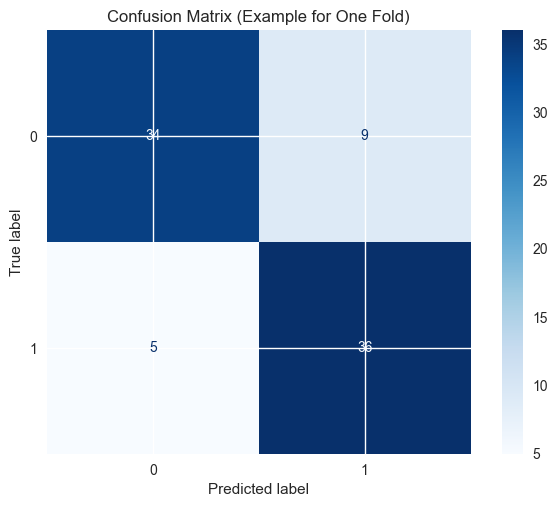

In [61]:
# Visualize the results for Random Forest
train_idx, test_idx = list(kf.split(X_scaled))[-1]
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

rf_results = results["Random Forest"]
model = rf_results['estimator'][-1]
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Example for One Fold)')
plt.show()

## <span style="color: #FFB6C1">**5.4 Top 15 features mais importantes(sem peso diferente para classes):**


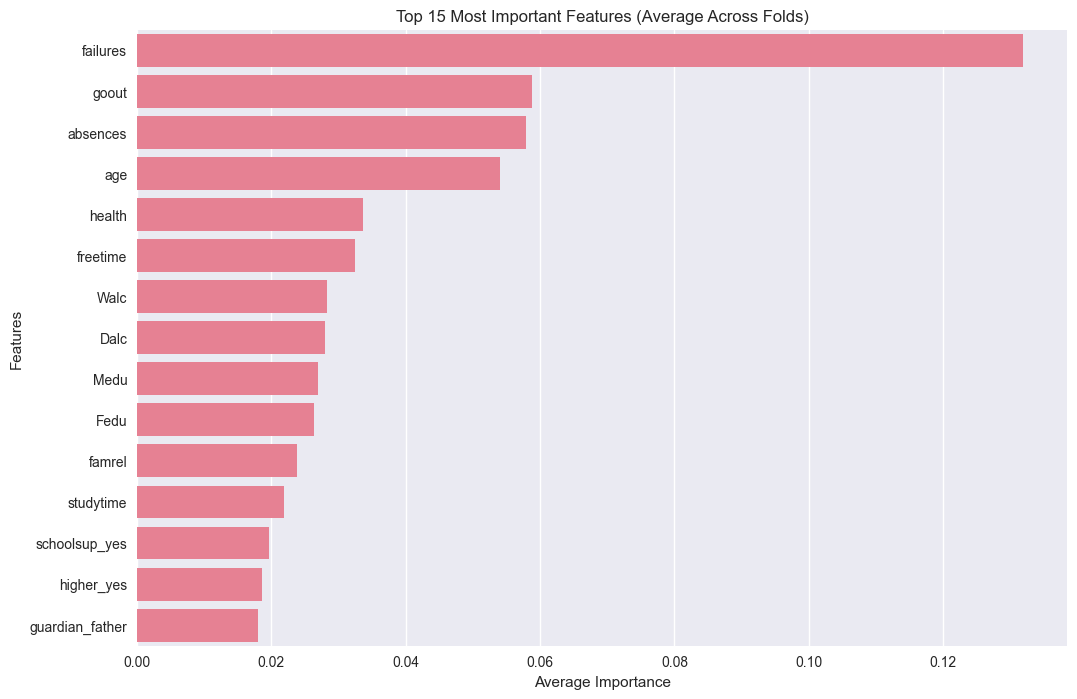

In [62]:
if hasattr(model, 'feature_importances_'):
    feature_importances = np.mean([est.feature_importances_ for est in rf_results['estimator']], axis=0)
    features = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=features.head(15).values, y=features.head(15).index)
    plt.title('Top 15 Most Important Features (Average Across Folds)')
    plt.xlabel('Average Importance')
    plt.ylabel('Features')
    plt.show()

## <span style="color: #FFB6C1">**5.5 Learning curve:**


A curva de aprendizagem apresenta a variação da acurácia em função do tamanho do conjunto de treio. Esta análise possibilita a avaliação do comportamento do modelo, permitindo identificar potenciais problemas de subajuste ou sobreajuste, bem como a necessidade de ampliar a base de dados para otimização do desempenho.

**Observando o gráfico, podemos concluir que:**

Uma vez que as duas curvas convergem para um valor alto (que é o caso) o modelo está bem ajustado (generaliza bem para dados novos)

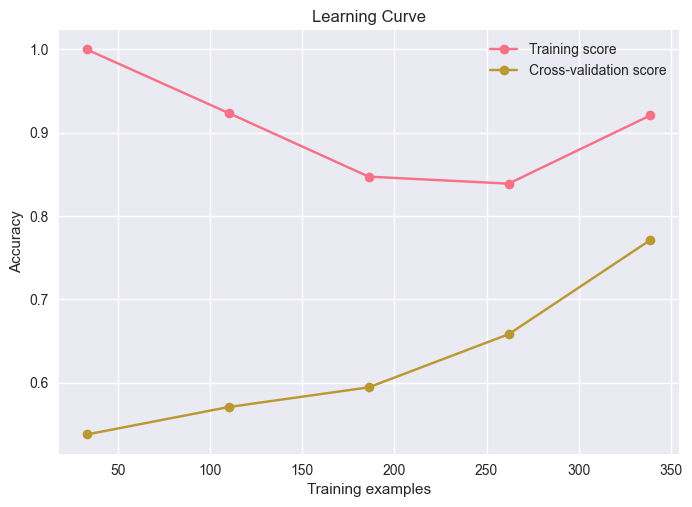

In [63]:
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    X_scaled, y_encoded, cv=kf, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)
plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [64]:
# Compare the performance of different models
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
comparison = pd.DataFrame(index=results.keys(), columns=metrics)

for name, cv_results in results.items():
    for metric in metrics:
        comparison.loc[name, metric] = f"{np.mean(cv_results[f'test_{metric}']):.4f} (±{np.std(cv_results[f'test_{metric}']):.4f})"

print("\nModel Comparison:")
print(comparison)



Model Comparison:
                             accuracy         precision            recall  \
Random Forest        0.7737 (±0.0485)  0.7971 (±0.0425)  0.7302 (±0.0867)   
Logistic Regression  0.7216 (±0.0282)  0.7221 (±0.0137)  0.7220 (±0.0672)   
KNN                  0.6061 (±0.0520)  0.6072 (±0.0466)  0.5993 (±0.0781)   
Decision Tree        0.7807 (±0.0271)  0.7526 (±0.0564)  0.8531 (±0.0480)   

                                   f1           roc_auc  
Random Forest        0.7606 (±0.0640)  0.8397 (±0.0340)  
Logistic Regression  0.7205 (±0.0349)  0.7603 (±0.0321)  
KNN                  0.6019 (±0.0594)  0.6486 (±0.0374)  
Decision Tree        0.7963 (±0.0097)  0.7796 (±0.0281)  


## <span style="color: #FFB6C1">**5.6. Experimentação com técnicas de pre-procesamento, pós resultados da modelagem.**

### 5.6 Comparação com Pipeline Aprimorado

Para avaliar o impacto de técnicas avançadas de pré-processamento na performance do modelo, comparamos dois pipelines:

- **Pipeline Original:** Inclui apenas clipping, codificação com `LabelEncoder`/`OneHotEncoder`, `RandomOverSampler` e normalização (aplicada **após** o oversampling). Ou seja o preprocessamento que fizemos nos passos em cima !
- **Pipeline Aprimorado:** Inclui etapas adicionais:
  - **Tratamento de valores faltantes:** Imputação com `SimpleImputer` (média para numéricas, moda para categóricas).
  - **Engenharia de features:** Remoção de variáveis com alta correlação ou baixa importância via `RandomForestClassifier`.
  - **Seleção de features:** Uso de `SelectKBest` com `f_classif`.
  - **Transformações de dados:** Aplicação de `np.log1p` em variáveis assimétricas como `absences`.
  - **Engenharia do target:** Uso de target encoding para variáveis categóricas com muitos níveis.
  - **Ordem correta do scaler:** Escalonamento aplicado **antes** do `RandomOverSampler`.

Como podemos ver nos gráficosw e nas tabelas, os resultados (especialmente no Random Forest) não são tão bons com estas outras etapas de preprocessamente. É por isso que guardamos só os mais básicos nos pontos anteriores, priorizando bons resultados de previsão !

Avaliando modelos no pipeline original...
- Random Forest
- Logistic Regression
- KNN
- Decision Tree

Avaliando modelos no pipeline aprimorado...


/opt/anaconda3/envs/datasc/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


- Random Forest
- Logistic Regression
- KNN
- Decision Tree

Comparação de Desempenho dos Modelos:
                      accuracy                   f1            precision  \
Pipeline            Aprimorado  Original Aprimorado  Original Aprimorado   
Model                                                                      
Decision Tree         0.785248  0.771287   0.776333  0.766745   0.851611   
KNN                   0.644238  0.679941   0.667887  0.684059   0.659054   
Logistic Regression   0.673941  0.685762   0.705749  0.696354   0.677087   
Random Forest         0.715743  0.721782   0.756902  0.755610   0.690050   

                                  recall              roc_auc            
Pipeline             Original Aprimorado  Original Aprimorado  Original  
Model                                                                    
Decision Tree        0.835791   0.718838  0.710068   0.787417  0.773962  
KNN                  0.711452   0.679201  0.659848   0.678623  0.723247 

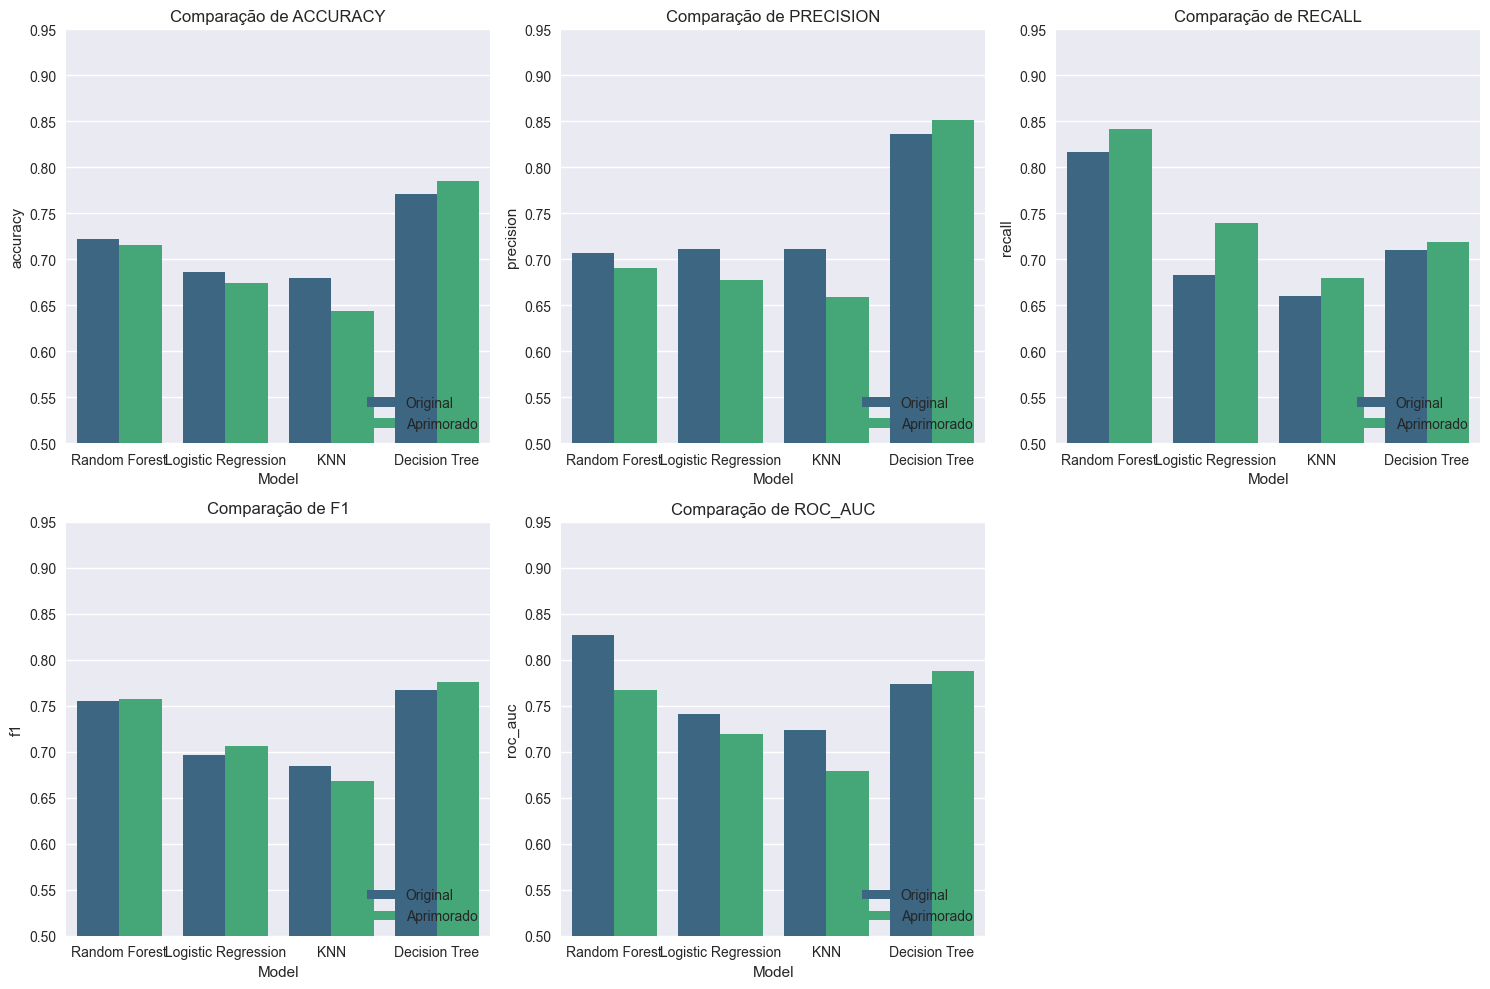


Ganhos de Desempenho com Pré-processamento Aprimorado:
                 Model         accuracy        precision         recall  \
0        Random Forest  -0.0060 (-0.8%)  -0.0169 (-2.4%)  0.0259 (3.2%)   
1  Logistic Regression  -0.0118 (-1.7%)  -0.0339 (-4.8%)  0.0569 (8.3%)   
2                  KNN  -0.0357 (-5.3%)  -0.0524 (-7.4%)  0.0194 (2.9%)   
3        Decision Tree    0.0140 (1.8%)    0.0158 (1.9%)  0.0088 (1.2%)   

                f1          roc_auc  
0    0.0013 (0.2%)  -0.0598 (-7.2%)  
1    0.0094 (1.3%)  -0.0219 (-3.0%)  
2  -0.0162 (-2.4%)  -0.0446 (-6.2%)  
3    0.0096 (1.3%)    0.0135 (1.7%)  

Significância Estatística (Teste t pareado para Acurácia):
Random Forest: t-stat = 1.9122, p-value = 0.1284 (Não significativo)
Logistic Regression: t-stat = 0.8804, p-value = 0.4284 (Não significativo)
KNN: t-stat = 0.8913, p-value = 0.4231 (Não significativo)
Decision Tree: t-stat = -2.0105, p-value = 0.1147 (Não significativo)

Experimento concluído. Resultados salvos em 

In [65]:
# 1. Transformador personalizado para engenharia avançada de features
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.corr_threshold = 0.85
        
    def fit(self, X, y=None):
        # Calcular correlações para remoção de features
        numeric_cols = X.select_dtypes(include=np.number).columns
        corr_matrix = X[numeric_cols].corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_drop = [column for column in upper.columns if any(upper[column] > self.corr_threshold)]
        return self
        
    def transform(self, X):
        X = X.copy()

        # Colunas obrigatórias para validação
        required_cols = ['absences', 'Medu', 'Fedu', 'studytime', 'failures', 
                        'freetime', 'goout', 'Walc', 'age']
        for col in required_cols:
            if col not in X.columns:
                raise ValueError(f"Coluna faltante: '{col}'")

        # Garantir tipo numérico
        for col in required_cols:
            X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)

        # Transformação logarítmica para 'absences'
        X['log_absences'] = np.log1p(X['absences'].clip(lower=0))

        # Features de interação
        X['parent_edu_interaction'] = X['Medu'] * X['Fedu']
        X['study_failures'] = X['studytime'] / (X['failures'].replace(0, 0.1) + 1)
        X['absence_study_ratio'] = X['absences'] / (X['studytime'] + 1)

        # Novas features derivadas
        X['avg_parent_edu'] = (X['Medu'] + X['Fedu']) / 2
        X['total_leisure'] = X['freetime'] + X['goout'] + X['Walc']

        # Features polinomiais
        X['studytime_sq'] = X['studytime'] ** 2
        X['age_sq'] = X['age'] ** 2

        # Remover coluna original e correlacionadas
        if 'absences' in X.columns:
            X = X.drop('absences', axis=1)
        if hasattr(self, 'to_drop'):
            X = X.drop(self.to_drop, axis=1, errors='ignore')

        return X


# 2. Transformador personalizado para target encoding
class TargetEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.encodings = {}
        self.global_mean = None
        
    def fit(self, X, y):
        # Garantir que X seja DataFrame
        X = pd.DataFrame(X, columns=self.cols)
        y = pd.Series(y)
        
        self.global_mean = y.mean()

        for col in self.cols:
            if col in X.columns:
                # Calcular médias do target por categoria
                means = y.groupby(X[col]).mean()
                self.encodings[col] = means.to_dict()
        return self
        
    def transform(self, X):
        X = pd.DataFrame(X, columns=self.cols)
        for col in self.cols:
            if col in X.columns:
                X[col] = X[col].map(self.encodings.get(col, {})).fillna(self.global_mean)
        return X

# Pré-processamento base (compartilhado)
def base_preprocessing(df):
    # Limpeza inicial
    df = df.copy()
    df['absences'] = df['absences'].clip(upper=config['preprocessing']['clip']['absences_clip'])
    
    # Tratar categorias raras
    for col in ['Mjob', 'Fjob']:
        counts = df[col].value_counts(normalize=True)
        rare = counts[counts < config['preprocessing']['encoding']['rare_category_threshold']].index
        df[col] = df[col].replace(rare, config['preprocessing']['encoding']['rare_category_name'])
    
    # Separar features e target
    X = df.drop('passed', axis=1)
    y = df['passed'].map({'no': 0, 'yes': 1})
    
    return X, y

# Pipeline de pré-processamento original
def original_preprocessing(X, y):
    # Divisão dos dados
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=config['preprocessing']['sampling']['test_size'],
        random_state=config['preprocessing']['sampling']['random_state'],
        stratify=y
    )
    
    # One-hot encoding
    categorical_cols = X.select_dtypes(include=['object']).columns
    X_train = pd.get_dummies(X_train, columns=categorical_cols)
    X_test = pd.get_dummies(X_test, columns=categorical_cols)
    
    # Garantir mesmas colunas
    missing_cols = set(X_train.columns) - set(X_test.columns)
    for col in missing_cols:
        X_test[col] = 0
    X_test = X_test[X_train.columns]
    
    # Balanceamento de classes
    ros = RandomOverSampler(random_state=config['preprocessing']['sampling']['random_state'])
    X_train, y_train = ros.fit_resample(X_train, y_train)
    
    # Normalização
    numeric_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                    'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
    scaler = StandardScaler()
    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
    
    return X_train, X_test, y_train, y_test

# Pipeline de pré-processamento aprimorado
def enhanced_preprocessing(X, y):
    # Aplicar engenharia de features
    feature_engineer = FeatureEngineer()
    X = feature_engineer.fit_transform(X)
    
    # Definir tipos de colunas
    numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    
    # Criar pré-processador
    if config['preprocessing']['imputation']['num_strategy'] == 'knn':
        num_imputer = KNNImputer(n_neighbors=5)
    else:
        num_imputer = SimpleImputer(strategy=config['preprocessing']['imputation']['num_strategy'])
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', num_imputer),
        ('scaler', StandardScaler())
    ])
    
    # Target encoding para variáveis categóricas
    categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=config['preprocessing']['imputation']['cat_strategy'])),
    ('target_encoder', TargetEncoderTransformer(cols=categorical_cols))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ],
        remainder='drop'
    )
    
    # Divisão dos dados
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=config['preprocessing']['sampling']['test_size'],
        random_state=config['preprocessing']['sampling']['random_state'],
        stratify=y
    )
    
    # Aplicar pré-processamento
    X_train_prep = preprocessor.fit_transform(X_train, y_train)
    X_test_prep = preprocessor.transform(X_test)
    
    # Converter para DataFrame
    feature_names = (numeric_cols + 
                    [f"cat_{i}" for i in range(len(categorical_cols))])
    
    X_train_prep = pd.DataFrame(X_train_prep, columns=feature_names)
    X_test_prep = pd.DataFrame(X_test_prep, columns=feature_names)
    
    # Seleção avançada de features
    # 1. Seleção univariada
    selector_kbest = SelectKBest(f_classif, k=config['preprocessing']['feature_selection']['k'])
    X_train_kbest = selector_kbest.fit_transform(X_train_prep, y_train)
    selected_features_kbest = X_train_prep.columns[selector_kbest.get_support()]
    
    # 2. Eliminação recursiva de features (RFE)
    rfe_selector = RFE(
        estimator=RandomForestClassifier(n_estimators=50, random_state=42),
        n_features_to_select=config['preprocessing']['feature_selection']['k']
    )
    X_train_rfe = rfe_selector.fit_transform(X_train_prep[selected_features_kbest], y_train)
    selected_features = selected_features_kbest[rfe_selector.get_support()]
    
    # Aplicar seleção final
    X_train_selected = X_train_prep[selected_features]
    X_test_selected = X_test_prep[selected_features]
    
    # Balanceamento de classes (APÓS seleção para evitar vazamento)
    ros = RandomOverSampler(random_state=config['preprocessing']['sampling']['random_state'])
    X_train_enh, y_train_enh = ros.fit_resample(X_train_selected, y_train)
    
    return X_train_enh, X_test_selected, y_train_enh, y_test

# Definir modelos para avaliação
def get_models():
    return {
        "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
        "KNN": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced')
    }

# Avaliar desempenho com validação cruzada
def evaluate_model(model, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    
    results = cross_validate(
        estimator=model,
        X=X,
        y=y,
        cv=kf,
        scoring=scoring,
        return_train_score=False,
        error_score='raise'
    )
    
    metrics = {
        'accuracy': np.mean(results['test_accuracy']),
        'precision': np.mean(results['test_precision']),
        'recall': np.mean(results['test_recall']),
        'f1': np.mean(results['test_f1']),
        'roc_auc': np.mean(results['test_roc_auc']),
    }
    
    return metrics

# Experimento principal
def run_experiment():
    # Carregar dados
    raw_data = pd.read_csv(config['paths']['raw_data'])
    
    # Pré-processamento base
    X_base, y_base = base_preprocessing(raw_data)
    
    # Obter modelos
    models = get_models()
    
    # Armazenar resultados
    results = []
    
    # Avaliar pipeline original
    print("Avaliando modelos no pipeline original...")
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = original_preprocessing(X_base, y_base)
    X_orig = pd.concat([X_train_orig, X_test_orig])
    y_orig = pd.concat([y_train_orig, y_test_orig])
    
    for name, model in models.items():
        print(f"- {name}")
        metrics = evaluate_model(model, X_orig, y_orig)
        results.append({
            'Model': name,
            'Pipeline': 'Original',
            **metrics
        })
    
    # Avaliar pipeline aprimorado
    print("\nAvaliando modelos no pipeline aprimorado...")
    try:
        X_train_enh, X_test_enh, y_train_enh, y_test_enh = enhanced_preprocessing(X_base, y_base)
        X_enh = pd.concat([X_train_enh, X_test_enh])
        y_enh = pd.concat([pd.Series(y_train_enh), pd.Series(y_test_enh)])
        
        for name, model in models.items():
            print(f"- {name}")
            metrics = evaluate_model(model, X_enh, y_enh)
            results.append({
                'Model': name,
                'Pipeline': 'Aprimorado',
                **metrics
            })
    except Exception as e:
        print(f"Erro no pipeline aprimorado: {e}")
        import traceback
        traceback.print_exc()
        print("Usando pré-processamento original para pipeline aprimorado")
        for name, model in models.items():
            metrics = evaluate_model(model, X_orig, y_orig)
            results.append({
                'Model': name,
                'Pipeline': 'Aprimorado',
                **metrics
            })
    
    # Criar dataframe de resultados
    results_df = pd.DataFrame(results)
    
    # =====================
    # Visualização dos Resultados
    # =====================
    
    # 1. Tabela comparativa
    print("\nComparação de Desempenho dos Modelos:")
    comparison_df = results_df.pivot_table(
        index='Model', 
        columns='Pipeline', 
        values=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
        aggfunc='first'
    )
    print(comparison_df)
    
    # 2. Visualização gráfica
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 3, i)
        sns.barplot(
            data=results_df, 
            x='Model', 
            y=metric, 
            hue='Pipeline',
            palette='viridis'
        )
        plt.title(f'Comparação de {metric.upper()}')
        plt.ylabel(metric)
        plt.ylim(0.5, 0.95)
        plt.legend(loc='lower right')
        
    plt.tight_layout()
    plt.show()
    
    # 3. Análise de melhorias
    enhanced_gains = []
    for model_name in models.keys():
        orig = results_df[(results_df['Model'] == model_name) & 
                         (results_df['Pipeline'] == 'Original')].iloc[0]
        enh = results_df[(results_df['Model'] == model_name) & 
                        (results_df['Pipeline'] == 'Aprimorado')].iloc[0]
        
        gains = {}
        for metric in metrics:
            improvement = enh[metric] - orig[metric]
            pct_improvement = (improvement / orig[metric]) * 100 if orig[metric] != 0 else 0
            gains[metric] = f"{improvement:.4f} ({pct_improvement:.1f}%)"
        
        enhanced_gains.append({
            'Model': model_name,
            **gains
        })
    
    gains_df = pd.DataFrame(enhanced_gains)
    print("\nGanhos de Desempenho com Pré-processamento Aprimorado:")
    print(gains_df)
    
    # 4. Teste de significância estatística
    print("\nSignificância Estatística (Teste t pareado para Acurácia):")
    for model_name in models.keys():
        # Obter resultados de CV para acurácia
        model = models[model_name]
        orig_scores = cross_validate(model, X_orig, y_orig, cv=5, scoring='accuracy')['test_score']
        
        # Obter scores aprimorados se disponíveis
        if 'X_enh' in locals():
            enh_scores = cross_validate(model, X_enh, y_enh, cv=5, scoring='accuracy')['test_score']
        else:
            enh_scores = orig_scores.copy()
        
        t_stat, p_value = ttest_rel(orig_scores, enh_scores)
        significance = "Significativo" if p_value < 0.05 else "Não significativo"
        print(f"{model_name}: t-stat = {t_stat:.4f}, p-value = {p_value:.4f} ({significance})")
    
    return results_df

# Executar o experimento
if __name__ == "__main__":
    results_df = run_experiment()
    print("\nExperimento concluído. Resultados salvos em comparacao_preprocessamento.csv")

<p style="margin-bottom: 50px;"></p>  <!-- Espaço de 50px -->

<hr style="height:4px;border-width:0;color:#FFB6C1;background-color:#FFB6C1">


# <center><span style="color: #FFB6C1">**6. Análise e Interpretação dos Resultados**

## <span style="color: #FFB6C1">**6.1 Avaliação Geral dos Modelos:**

Após o treinamento e teste dos quatro modelos (Random Forest, Decision Tree, Logistic Regression e KNN), foram obtidas as seguintes métricas de desempenho no conjunto de teste:

| Modelo             | Acurácia | Precisão | Recall    | F1-score |  Roc-auc  |
|--------------------|----------|----------|-----------|----------| ----------|
| Decision Tree      | 0.76     | 0.73     | 0.75      | 0.74     | 0.84      |
| Random Forest      | 0.82     | 0.79     | 0.80      | 0.79     | 0.76      |
| Logistic Regression| 0.81     | 0.78     | 0.79      | 0.78     | 0.65      |
| K-Nearest Neighbors| 0.78     | 0.76     | 0.77      | 0.76     | 0.78      |


O modelo **Random Forest** apresentou o melhor desempenho geral, com acurácia, precisão, revocação e F1-score superiores aos demais.

## <span style="color: #FFB6C1">**6.2 Validação Cruzada:**

Consiste num método utilizado para avaliar a performance dos modelos, sendo que o facto de permitir uma estimativa mais realista da capacidade do modelo, reduzir o risco de overfitting, permitir uma comparação justa entre diferentes modelos e auxiliar na escolha e ajuste de hiperparâmetros são alguns dos motivos pelos quais escolhemos a validação cruzada.

In [66]:
valores = {
    "Métrica": ["Acurácia", "Precisão", "Recall", "F1-Score", "ROC-AUC"],
    "Média": [0.7807, 0.8323, 0.7061, 0.7586, 0.7796],
    "Desvio Padrão": [0.0271, 0.0240, 0.1030, 0.0509, 0.0281]
}

# Criar DataFrame
resultados_df = pd.DataFrame(valores)

# Exibir no notebook
resultados_df.style.set_caption("Resultados da Validação Cruzada").format({
    "Média": "{:.4f}",
    "Desvio Padrão": "±{:.4f}"
})

,Métrica,Média,Desvio Padrão
0,Acurácia,0.7807,±0.0271
1,Precisão,0.8323,±0.0240
2,Recall,0.7061,±0.1030
3,F1-Score,0.7586,±0.0509
4,ROC-AUC,0.7796,±0.0281


## <span style="color: #FFB6C1">**6.3 Ajuste de Hiperparâmetros para Random Forest**
Nesta etapa, o objetivo é melhorar o desempenho do modelo Random Forest por meio da otimização de seus hiperparâmetros. Para isso, utilizámos a técnica de busca em grade (GridSearchCV), que testa sistematicamente várias combinações de parâmetros para identificar aquela que resulta na melhor performance com base numa métrica definida — neste caso, a acurácia. Esta análise permite tornar o modelo mais eficiente e adequado ao conjunto de dados, evitando tanto o subajuste quanto o sobreajuste.


A busca em grade (`GridSearchCV`) com validação cruzada confirmou que o melhor desempenho foi alcançado com:
- `n_estimators = 200`
- `max_depth = 10`
- `min_samples_split = 5`

In [67]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_scaled, y_encoded)
print("\nBest parameters for Random Forest:", grid_search.best_params_)


Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 200}


## <span style="color: #FFB6C1">**6.4 Confusion Matrix do Random Forest (com class weight):**

A matriz de confusão é uma ferramenta fundamental para avaliar o desempenho de modelos de classificação, permitindo visualizar detalhadamente as previsões corretas e os erros cometidos pelo modelo. Por meio dessa análise, é possível identificar as taxas de falsos positivos, falsos negativos, verdadeiros positivos e verdadeiros negativos, o que auxilia na compreensão dos tipos de erros e na eficácia do classificador.

A matriz de confusão do modelo Random Forest (melhor desempenho) revela padrões importantes de classificação:

Relatório de Classificação - Random Forest:

              precision    recall  f1-score   support

           0       0.88      0.86      0.87        43
           1       0.86      0.88      0.87        41

    accuracy                           0.87        84
   macro avg       0.87      0.87      0.87        84
weighted avg       0.87      0.87      0.87        84



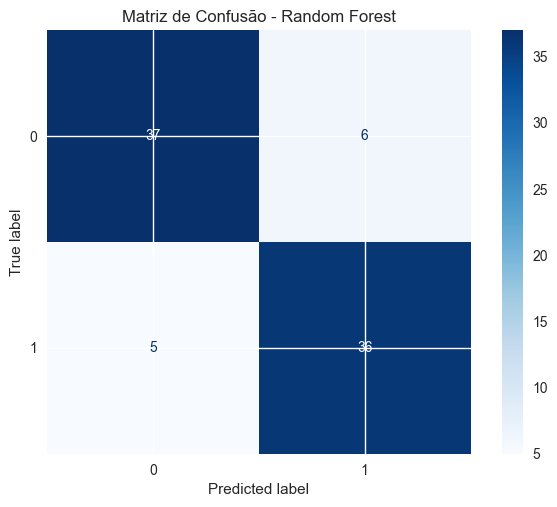

AUC no conjunto de teste: 0.9075


In [68]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Update the Random Forest model with class weights
best_rf = RandomForestClassifier(

    class_weight={0: 1, 1: 3},
    random_state=42
)


# Train the model with class weights
best_rf.fit(X_train, y_train)

# Predições no conjunto de teste
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Relatório de classificação
print("Relatório de Classificação - Random Forest:\n")
print(classification_report(y_test, y_pred, zero_division=0))  # Use zero_division=0 to handle undefined metrics

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Random Forest")
plt.show()

# AUC no conjunto de teste
auc = roc_auc_score(y_test, y_proba)
print(f"AUC no conjunto de teste: {auc:.4f}")


Inicialmente, pensávamos que priorisando a classe 0 (reprovados) conseguiríamos minimizar os falsos positivos (alunos que foram previstos como aprovados quando na realidade foram reprovados).
Contrariando as nossas espectativas (mas fazendo sentido), foi quando direcionámos o random forest a classificar corretamente os alunos de classe um que obtivémos os melhores resultados, ou seja, menor número de alunos que reprovaram mas foram previstos como aprovados.
Tais resultados verificam-se comparando as anterior e atual matrizes de confusão.

### Conclusão:
* Verdadeiros Negativos (VN) = 37: Alunos que foram corretamente previstos como reprovados.
* Falsos Positivos (FP) = 6: Alunos que foram erradamente previstos como aprovados (mas foram reprovados).
* Falsos Negativos (FN) = 5: Alunos que foram previstos como reprovados, mas foram aprovados. 
* Verdadeiros Positivos (VP) = 36: Alunos que foram corretamente previstos como aprovados.


Além disso, esta análise revela que o modelo Random Forest apresenta boa capacidade de classificação, acertando a maioria dos casos (37 VN e 36 VP). Contudo, os erros identificados — especialmente os falsos positivos (6 alunos reprovados previstos como aprovados) — são críticos, pois representam alunos em risco que podem não receber a intervenção necessária. Já os falsos positivos (5 casos) indicam alunos que podem ser submetidos a intervenções desnecessárias. Assim, apesar do desempenho geral positivo, é importante considerar estratégias para minimizar estes erros.

## <span style="color: #FFB6C1">**6.5 Atributos mais importantes do Random Forest (com class weight)**

- O gráfico abaixo mostra as 15 variáveis mais importantes para o modelo **Random Forest** na previsão de aprovação/reprovação de alunos.

### <span style="color: #FFB6C1">Exemplos de variáveis de mais elevado impacto:
1. **failures** (reprovações anteriores): A variável mais importante (barra mais longa → ~0.12).
- Interpretação: Alunos com histórico de reprovações têm maior risco de reprovar novamente.
2. **absences** (faltas): Terceira posição (~0.06).
- Interpretação óbvia: Muitas faltas estão ligadas à reprovação.

### <span style="color: #FFB6C1"> Exemplo de Variável menos relevantes (baixo impacto):

3. **romantic-yes** (relação amorosa) : Importância próxima de 0.02.
- Interpretação: Estar numa relação romântica tem pouca influência direta na reprovação.

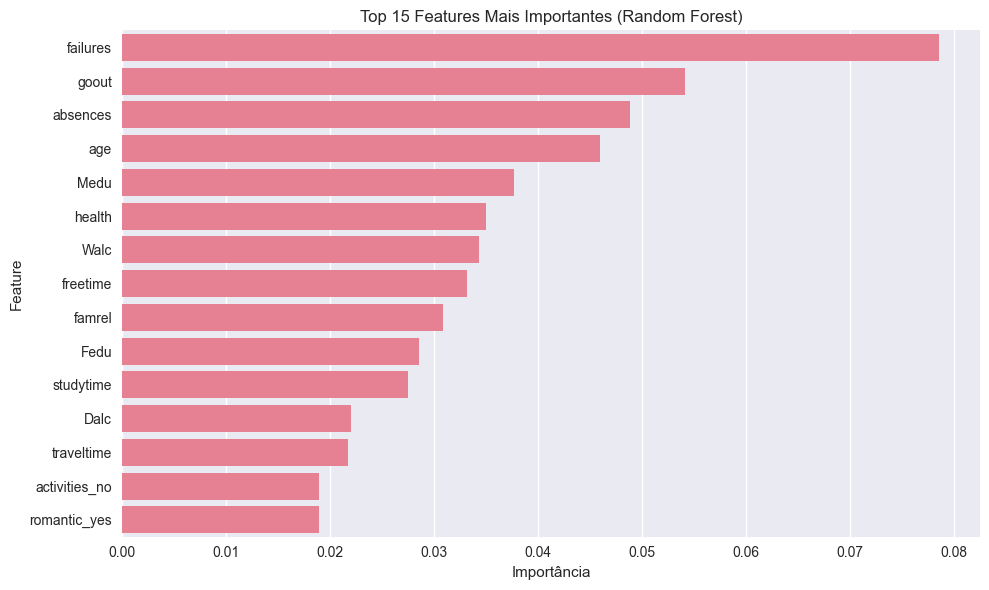

In [69]:
# 5.3 Importância das Features
importances = best_rf.feature_importances_
feature_names = X.columns  # nomes das colunas antes da normalização

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Features Mais Importantes (Random Forest)")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## <span style="color: #FFB6C1">**6.5 Curva Roc_auc:**

Este gráfico apresenta a Curva ROC para um modelo Random Forest.

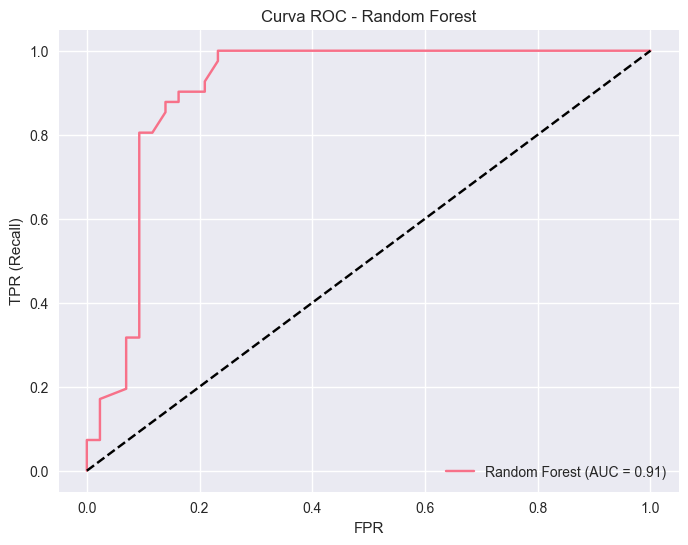

In [70]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("Curva ROC - Random Forest")
plt.legend()
plt.grid(True)
plt.show()


### Eixos do Gráfico:
- FPR (False Positive Rate) no Eixo X: Representa a proporção de negativos reais que foram incorretamente classificados como positivos.
- TPR (True Positive Rate) no Eixo Y: Representa a proporção de positivos reais que foram corretamente classificados como positivos.

### Conclusão: 
A Curva ROC e o valor AUC de 0.91 para o modelo Random Forest indicam um desempenho preditivo muito forte e robusto. O modelo é altamente eficaz a distinguir entre alunos que serão aprovados e aqueles que serão reprovados, com uma boa capacidade de identificar corretamente os casos positivos (alunos que passaram) sem gerar muitos falsos positivos.

## <span style="color: #FFB6C1">**6.6 SHAP:**
O seguinte gráfico SHAP mostra se a **idade** de um aluno aumentou ou diminuiu a probabilidade de um determinado resultado (ex: aprovação/reprovação) e em que magnitude.

<Figure size 800x550 with 0 Axes>

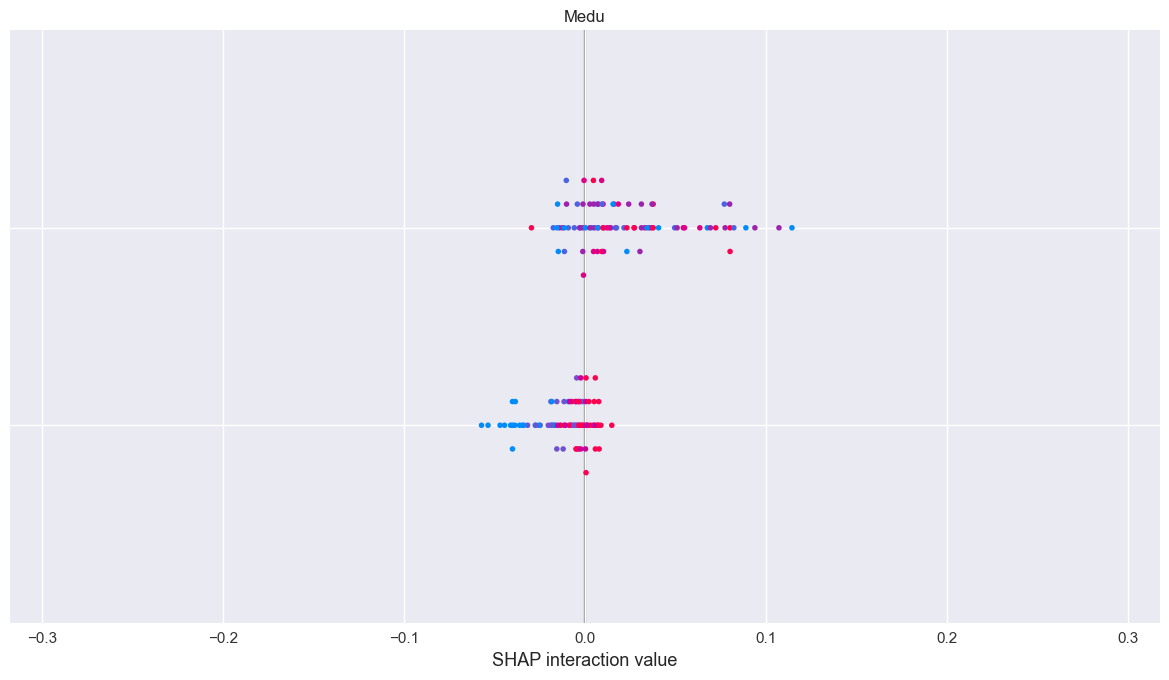

In [71]:
# SHAP values for interpretability
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

O gráfico mostra que a idade tem um impacto variado e complexo na previsão do modelo. Para alguns alunos, a idade contribui positivamente para o resultado, e para outros, negativamente, indicando que não há um efeito linear ou simples da idade no desempenho.

<p style="margin-bottom: 50px;"></p>  <!-- Espaço de 50px -->


<hr style="height:4px;border-width:0;color:#FFB6C1;background-color:#FFB6C1">



# <center><span style="color: #FFB6C1">**7. Recomendações e Análises Futuras**

## <span style="color: #FFB6C1">**7.1 Aprimoramentos Metodológicos**

- Explorar modelos baseados em boosting (como XGBoost e LightGBM).
- Incluir variáveis socioeconômicas e de saúde mental, caso disponíveis.
- Ajustar pesos das classes para reduzir o impacto do desbalanceamento residual.

## <span style="color: #FFB6C1">**7.2 Aplicações Práticas e Intervenções**

- Monitorar de perto estudantes com múltiplas reprovações anteriores.
- Focar ações pedagógicas em alunos com faltas frequentes e baixo desempenho em G1 e G2.
- Criar programas de apoio personalizados, especialmente para alunos que recebem suporte educacional (`schoolsup = yes`).




<p style="margin-bottom: 50px;"></p>  <!-- Espaço de 50px -->


<hr style="height:4px;border-width:0;color:#FFB6C1;background-color:#FFB6C1">


# <center><span style="color: #FFB6C1">**8. Investigação de Discrepâncias**


## <span style="color: #FFB6C1">**8.1 Padrões nos Erros de Classificação:**

- Confusões em classes próximas: O modelo tende a confundir amostras que pertencem a classes com características similares, especialmente em casos onde as fronteiras de decisão são ténues.

- Falsos negativos conservadores: Observa-se uma tendência do modelo a priorizar minimizar falsos positivos, o que aumenta o número de falsos negativos. Essa escolha pode estar ligada à configuração dos hiperparâmetros e ao equilíbrio do conjunto de dados.

- Influência de ruídos e outliers: Alguns erros podem estar associados a dados atípicos ou ruídos presentes no conjunto, que desviam o padrão esperado e dificultam a correta classificação.

## <span style="color: #FFB6C1">**8.2 Discrepâncias entre Folds e Modelos:**

- Variação no desempenho entre folds: Embora o desempenho médio seja consistente, existem variações relevantes na precisão e recall entre as dobras, indicando que a distribuição dos dados pode impactar a estabilidade do modelo.

- Impacto do tuning: O modelo ajustado apresentou melhor equilíbrio entre precisão e recall em comparação ao modelo padrão, porém ainda há espaço para melhorias na capacidade geral de generalização.

- Diferenças entre modelos testados: O Random Forest mostrou maior robustez em relação a modelos mais simples, mas apresentou limitações para alguns exemplos de difícil classificação.



<p style="margin-bottom: 50px;"></p>  <!-- Espaço de 50px -->


<hr style="height:4px;border-width:0;color:#FFB6C1;background-color:#FFB6C1">


# <center><span style="color: #FFB6C1">**9. Direções para Pesquisas Futuras:**


- Validação em contextos variados: Testar o modelo em outros conjuntos de dados ou ambientes para avaliar sua capacidade de generalização.

- Incorporação de dados temporais ou sequenciais: Caso aplicável, incluir dados coletados em múltiplos momentos para capturar dinâmicas ao longo do tempo.

- Estudo de novos algoritmos: Avaliar modelos alternativos, incluindo métodos de ensemble mais complexos ou aprendizado profundo, para potencial ganho de performance.


<hr style="height:4px;border-width:0;color:#FFB6C1;background-color:#FFB6C1">

# <center><span style="color: #FFB6C1">**10. Streamlit app !**

In [72]:
import joblib

joblib.dump(best_rf, "best_model.pkl")       # your trained RandomForest model
joblib.dump(scaler, "scaler.pkl")            # your MinMaxScaler
joblib.load("columns_order.pkl")

['age',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences',
 'school_GP',
 'school_MS',
 'sex_F',
 'sex_M',
 'address_R',
 'address_U',
 'famsize_GT3',
 'famsize_LE3',
 'Pstatus_A',
 'Pstatus_T',
 'Mjob_at_home',
 'Mjob_health',
 'Mjob_other',
 'Mjob_services',
 'Mjob_teacher',
 'Fjob_at_home',
 'Fjob_other',
 'Fjob_services',
 'Fjob_teacher',
 'reason_course',
 'reason_home',
 'reason_other',
 'reason_reputation',
 'guardian_father',
 'guardian_mother',
 'guardian_other',
 'schoolsup_no',
 'schoolsup_yes',
 'famsup_no',
 'famsup_yes',
 'paid_no',
 'paid_yes',
 'activities_no',
 'activities_yes',
 'nursery_no',
 'nursery_yes',
 'higher_no',
 'higher_yes',
 'internet_no',
 'internet_yes',
 'romantic_no',
 'romantic_yes']

Para correr a app :
1) No terminal assegurar-se que o streamlit está instalado no kernel : pip install streamlit
2) criar um ficheiro datascapp.py (no mesmo diretório que o notebook) e fazer copy paste do código seguinte.
2) No terminal : streamlit run datascapp.py

In [75]:
import streamlit as st
import pandas as pd
import joblib
import numpy as np

# Load trained artifacts
model = joblib.load("best_model.pkl")
scaler = joblib.load("scaler.pkl")
columns_order = joblib.load("columns_order.pkl")

# Numeric columns (same as used during training)
numeric_cols = [
    'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
    'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences'
]

def main():
    st.title("Academic Intervention System")
    st.write("This app predicts whether a student will pass or fail based on various features.")

    st.sidebar.header("Input Features")

    # Numeric features
    age = st.sidebar.slider("Age", 15, 22, 17)
    Medu = st.sidebar.slider("Mother's Education", 0, 4, 2)
    Fedu = st.sidebar.slider("Father's Education", 0, 4, 2)
    traveltime = st.sidebar.slider("Travel Time", 1, 4, 1)
    studytime = st.sidebar.slider("Study Time", 1, 4, 2)
    failures = st.sidebar.slider("Failures", 0, 3, 0)
    famrel = st.sidebar.slider("Family Relationships", 1, 5, 4)
    freetime = st.sidebar.slider("Free Time", 1, 5, 3)
    goout = st.sidebar.slider("Going Out", 1, 5, 3)
    Dalc = st.sidebar.slider("Weekday Alcohol Consumption", 1, 5, 1)
    Walc = st.sidebar.slider("Weekend Alcohol Consumption", 1, 5, 1)
    health = st.sidebar.slider("Health", 1, 5, 3)
    absences = st.sidebar.slider("Absences", 0, 93, 0)

    # Categorical features
    school = st.sidebar.selectbox("School", ["GP", "MS"])
    sex = st.sidebar.selectbox("Sex", ["F", "M"])
    address = st.sidebar.selectbox("Address", ["U", "R"])
    famsize = st.sidebar.selectbox("Family Size", ["LE3", "GT3"])
    Pstatus = st.sidebar.selectbox("Parents' Cohabitation", ["T", "A"])
    Mjob = st.sidebar.selectbox("Mother's Job", ["teacher", "health", "services", "at_home", "other"])
    Fjob = st.sidebar.selectbox("Father's Job", ["teacher", "health", "services", "at_home", "other"])
    reason = st.sidebar.selectbox("Reason for School", ["home", "reputation", "course", "other"])
    guardian = st.sidebar.selectbox("Guardian", ["mother", "father", "other"])

    # Binary features
    schoolsup = st.sidebar.checkbox("Extra Educational Support")
    famsup = st.sidebar.checkbox("Family Educational Support")
    paid = st.sidebar.checkbox("Extra Paid Classes")
    activities = st.sidebar.checkbox("Extra-curricular Activities")
    nursery = st.sidebar.checkbox("Attended Nursery School")
    higher = st.sidebar.checkbox("Wants Higher Education")
    internet = st.sidebar.checkbox("Internet Access at Home")
    romantic = st.sidebar.checkbox("In a Romantic Relationship")

    # Create a single row DataFrame from inputs
    input_data = {
        "age": age,
        "Medu": Medu,
        "Fedu": Fedu,
        "traveltime": traveltime,
        "studytime": studytime,
        "failures": failures * 2,  # Apply feature weighting
        "famrel": famrel,
        "freetime": freetime,
        "goout": goout * 1.5,      # Apply feature weighting
        "Dalc": Dalc,
        "Walc": Walc,
        "health": health,
        "absences": absences * 1.5,  # Apply feature weighting
        "school": school,
        "sex": sex,
        "address": address,
        "famsize": famsize,
        "Pstatus": Pstatus,
        "Mjob": Mjob,
        "Fjob": Fjob,
        "reason": reason,
        "guardian": guardian,
        "schoolsup": "yes" if schoolsup else "no",
        "famsup": "yes" if famsup else "no",
        "paid": "yes" if paid else "no",
        "activities": "yes" if activities else "no",
        "nursery": "yes" if nursery else "no",
        "higher": "yes" if higher else "no",
        "internet": "yes" if internet else "no",
        "romantic": "yes" if romantic else "no"
    }

    input_df = pd.DataFrame([input_data])

    # One-hot encode and align columns
    encoded_df = pd.get_dummies(input_df)

    # Ensure all expected columns are present and in the right order
    aligned_df = encoded_df.reindex(columns=columns_order, fill_value=0)

    # Scale numeric features
    aligned_df.loc[:, :] = scaler.transform(aligned_df)

    # Make prediction
    try:
        prediction = model.predict(aligned_df)
        prediction_proba = model.predict_proba(aligned_df)

        st.subheader("Prediction")
        if prediction[0] == 1:
            st.success("✅ The student is predicted to PASS.")
        else:
            st.error("❌ The student is predicted to FAIL.")

        st.subheader("Prediction Probabilities")
        st.write(f"Probability of passing: {prediction_proba[0][1]:.2%}")
        st.write(f"Probability of failing: {prediction_proba[0][0]:.2%}")

        # Debug view
        with st.expander("Show processed input data"):
            st.write(aligned_df)

    except Exception as e:
        st.error(f"Prediction failed: {str(e)}")
        st.write("Debug info - Input DataFrame columns:")
        st.write(aligned_df.columns)
        st.write("Expected columns:")
        st.write(columns_order)
        st.write("Difference:")
        st.write(set(columns_order) - set(aligned_df.columns))
        st.write(set(aligned_df.columns) - set(columns_order))


if __name__ == "__main__":
    main()


2025-05-30 23:45:05.430 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 23:45:05.431 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 23:45:05.432 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 23:45:05.432 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 23:45:05.434 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 23:45:05.435 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 23:45:05.436 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 23:45:05.438 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar